## End-to-end error propagation: pulse fits → ratios → phase (closed form)

This is a closed-form uncertainty pipeline for the challenge: estimate a sinusoidal phase shift from ratio measurements derived from pulse fits.

## 0) Problem formulation

### Observations
For each run and condition (A or B), we have:
- Scan settings (independent variable): \($x_i$\) in degrees, \(i=1..N\) (typically \(N=50\)).
- A noisy time-series trace at each \($x_i$\): \($s_i(t_k)$\), sampled at \($k=1\cdots T$\).
- A known split time \($t_{\text{edge}}$\) separating Region 1 and Region 2.

### Target output
Estimate the **phase** \($\phi$\) of a sinusoid relating a derived scalar \($y_i$\) to scan \($x_i$\), and report \($\phi$\) with uncertainty (e.g., standard error or CI):
$$
\phi\;\pm\;\mathrm{SE}(\phi).
$$

### Derived scalar (ratio)
For each trace \($i$\), define two peak amplitudes:
- \($A_{1,i}$\): peak amplitude in **Region 1** (pre-\($t_{\text{edge}}$\)).
- \($A_{2,i}$\): peak amplitude in **Region 2** (post-\($t_{\text{edge}}$\)). In this challenge, Region 2 is treated as a **single composite pulse** (even if it is formed by multiple underlying Gaussians).

Then
$$
 y_i \;=\; \frac{A_{1,i}}{A_{2,i}}.
$$

Uncertainty propagation flows as:
$$
\text{trace noise}\;\Rightarrow\;\text{pulse-fit parameter uncertainty}\;\Rightarrow\;\text{peak uncertainty}\;\Rightarrow\;\text{ratio uncertainty}\;\Rightarrow\;\text{phase uncertainty}.
$$

---

## 1) Pulse model + fitting (per trace, per region)

### 1.1 Define your pulse model
For each trace \(i\), fit a parametric model separately in each region:
- Region 1 model: \($m_1(t;\theta_{1,i})$\)
- Region 2 model: \($m_2(t;\theta_{2,i})$\)

Examples:
- Gaussian + baseline: $m(t)=b + A\exp(-(t-\mu)^2/(2\sigma^2))$
- Template scaling + baseline: $m(t)=b + a\,g(t-\tau)$ where \($g$\) is a fixed template.

**Design choice:** In this assignment I considerd a few different optiosn for Region 2 model $m_2$: inlcluding a single Gaussin pulse, a summation of two Gaussina Pulses, or a summation of three Guassian Pulses. __I recognize the importance of what the Region 2 pulse actually represents and the assumptions involved; however, I tackled this problem primarily to illustrate my thought process.__

### 1.2 Fit parameters by (nonlinear) least squares
Let \($\mathbf{t}_r$\) and \($\mathbf{s}_{r,i}$\) be the time grid and samples in region \($r\in\{1,2\}$\) for trace \($i$\).

Fit:

$$\hat\theta_{r,i} \;=\; \arg\min_{\theta}\; \lVert \mathbf{s}_{r,i} - m_r(\mathbf{t}_r;\theta)\rVert^2.$$

  > Note: For the case of a single Gaussian pulse the above can be simplified to a ordinary linear least square by taking the $log$ of $m$ and $s$ values. But to keep it general I did not pursue that here. 

### 1.3 Estimate residual variance (noise level in the window)
Compute residuals:

$$\mathbf{e}_{r,i} = \mathbf{s}_{r,i} - m_r(\mathbf{t}_r;\hat\theta_{r,i}).$$

Estimate residual variance:

$$\hat\sigma^2_{r,i} = \frac{\sum_k e_{r,i}(k)^2}{n_r - p_r},$$

where \($n_r$\) is number of samples in region \($r$\) and \($p_r$\) is number of fitted parameters.

**Interpretation:** this \($\hat\sigma^2_{r,i}$\) is the local noise/mismatch level after fitting.

### 1.4 Parameter covariance from the Jacobian
Let \($J_{r,i}$\) be the Jacobian of the model w.r.t. parameters evaluated at \($\hat\theta_{r,i}$\):

$$J_{r,i}(k,:) = \left.\frac{\partial m_r(t_k;\theta)}{\partial \theta^T}\right|_{\theta=\hat\theta_{r,i}}.$$

Approximate parameter covariance (standard NLLS result):
$$
\boxed{\;\mathrm{Cov}(\hat\theta_{r,i})\;\approx\; \hat\sigma^2_{r,i}\,(J_{r,i}^T J_{r,i})^{-1}\;}
$$

**What this means:**
- Bigger residual variance \($\hat\sigma^2_{r,i}$\) → larger parameter uncertainty.
- Ill-conditioned \($J^T J$\) (non-identifiable fit) → large parameter uncertainty.

**Caveat (model mismatch):** this covariance assumes the model family is adequate. If the model is structurally wrong, covariance may understate bias. I will discuss this more later when looking the goodness of fit for different assumptions of Region 2 pulse.

---

## 2) Peak amplitude estimate + uncertainty (per trace)

### 2.1 Define peak as a function of parameters
Define the peak amplitude functional for each region:

$$A_{r,i} = f_r(\theta_{r,i}) \quad (r=1,2).$$



### 2.2 Propagate parameter covariance to peak variance (delta method)
Compute gradient at the estimate:

$$\mathbf{g}_{r,i} = \nabla_{\theta} f_r(\hat\theta_{r,i}).$$

Then
$$
\boxed{\;\mathrm{Var}(\hat A_{r,i}) \;\approx\; \mathbf{g}_{r,i}^T\;\mathrm{Cov}(\hat\theta_{r,i})\;\mathbf{g}_{r,i}\;}
$$
and \($\mathrm{SE}(\hat A_{r,i}) = \sqrt{\mathrm{Var}(\hat A_{r,i})}$\).

**Engineering note:** If \(A\) is a direct fitted parameter (very common), this reduces to just reading the appropriate diagonal entry of \($\mathrm{Cov}(\hat\theta)$\).

---

## 3) Ratio estimate + uncertainty (per trace)

### 3.1 Define ratio
\[
\hat y_i = \frac{\hat A_{1,i}}{\hat A_{2,i}}.
\]

### 3.2 Propagate peak uncertainties to ratio variance
Treat \(y(A_1,A_2)=A_1/A_2\). The gradient is:
\[
\frac{\partial y}{\partial A_1}=\frac{1}{A_2},\qquad
\frac{\partial y}{\partial A_2}=-\frac{A_1}{A_2^2}.
\]

General 2-variable propagation:
\[
\mathrm{Var}(\hat y_i) \approx
\nabla y^T
\begin{bmatrix}
\mathrm{Var}(\hat A_{1,i}) & \mathrm{Cov}(\hat A_{1,i},\hat A_{2,i})\\
\mathrm{Cov}(\hat A_{1,i},\hat A_{2,i}) & \mathrm{Var}(\hat A_{2,i})
\end{bmatrix}
\nabla y.
\]

Expanded:
\[
\boxed{\;\mathrm{Var}(\hat y_i)\approx
\left(\frac{1}{\hat A_{2,i}}\right)^2\!\mathrm{Var}(\hat A_{1,i})
+\left(\frac{\hat A_{1,i}}{\hat A_{2,i}^2}\right)^2\!\mathrm{Var}(\hat A_{2,i})
-2\left(\frac{\hat A_{1,i}}{\hat A_{2,i}^3}\right)\!\mathrm{Cov}(\hat A_{1,i},\hat A_{2,i})\;}
\]

**Typical simplification:** because regions are disjoint in time, it is often reasonable to assume
\(\mathrm{Cov}(\hat A_{1,i},\hat A_{2,i})\approx 0\), giving:
\[
\mathrm{Var}(\hat y_i)\approx
\left(\frac{1}{\hat A_{2,i}}\right)^2\!\mathrm{Var}(\hat A_{1,i})
+\left(\frac{\hat A_{1,i}}{\hat A_{2,i}^2}\right)^2\!\mathrm{Var}(\hat A_{2,i}).
\]

Define ratio standard deviation:
\[
 s_i \equiv \mathrm{SE}(\hat y_i) = \sqrt{\mathrm{Var}(\hat y_i)}.
\]

**Lay interpretation:** \(s_i\) is the typical jitter you’d expect in the ratio if you repeated the same trace measurement and refit.

---

## 4) Sinusoid fit for phase (across scan settings)

### 4.1 Linear-in-parameters sinusoid model
Fit the ratio-vs-scan relation:
\[
\hat y_i \approx c + b\sin(\omega x_i) + d\cos(\omega x_i) + \varepsilon_i,
\quad \omega=2\pi/360.
\]

Define design row:
\[
\mathbf{x}_i = [1,\;\sin(\omega x_i),\;\cos(\omega x_i)].
\]
Stack rows into matrix \(X\) and observations into vector \(\mathbf{y}\).

### 4.2 Use ratio uncertainties as weights (WLS)
Assume \(\mathrm{Var}(\varepsilon_i)\approx \mathrm{Var}(\hat y_i)=s_i^2\). Then set weights:
\[
 w_i = \frac{1}{s_i^2}.
\]
Let \(W=\mathrm{diag}(w_i)\).

Weighted least squares estimator:
\[
\boxed{\;\hat\beta = (X^T W X)^{-1} X^T W\mathbf{y},\quad \hat\beta=[\hat c,\hat b,\hat d]^T\;}
\]

### 4.3 Covariance of sinusoid parameters
If the \(s_i\) are absolute standard deviations (not just relative), then:
\[
\boxed{\;\mathrm{Cov}(\hat\beta) \approx (X^T W X)^{-1}\;}
\]

If weights are only relative (common), include a scale estimated from weighted residuals:
\[
\hat\sigma_w^2 = \frac{\sum_i w_i (y_i-\hat y_i)^2}{N-p},\quad
\mathrm{Cov}(\hat\beta) \approx \hat\sigma_w^2 (X^T W X)^{-1}.
\]

---

## 5) Phase estimate + uncertainty from \(b,d\)

### 5.1 Phase definition
With \(b\sin + d\cos\) form, define phase:
\[
\boxed{\;\hat\phi = \mathrm{atan2}(\hat d,\hat b)\;}
\]

### 5.2 Delta-method propagation to phase variance
Let \(\Sigma_{bd}\) be the 2×2 submatrix of \(\mathrm{Cov}(\hat\beta)\) corresponding to \((b,d)\):
\[
\Sigma_{bd}=
\begin{bmatrix}
\mathrm{Var}(\hat b) & \mathrm{Cov}(\hat b,\hat d)\\
\mathrm{Cov}(\hat b,\hat d) & \mathrm{Var}(\hat d)
\end{bmatrix}.
\]

For \(\phi=\atan2(d,b)\), gradient is:
\[
\frac{\partial \phi}{\partial b}= -\frac{d}{b^2+d^2},\qquad
\frac{\partial \phi}{\partial d}= \frac{b}{b^2+d^2}.
\]

Closed form:
\[
\boxed{\;\mathrm{Var}(\hat\phi)\approx
\frac{d^2\,\mathrm{Var}(b)+b^2\,\mathrm{Var}(d)-2bd\,\mathrm{Cov}(b,d)}{(b^2+d^2)^2}\;}
\]

Standard error:
\[
\boxed{\;\mathrm{SE}(\hat\phi)=\sqrt{\mathrm{Var}(\hat\phi)}\;}
\]
Convert to milliradians:
\[
\mathrm{SE}_{\mathrm{mrad}} = 1000\cdot \mathrm{SE}(\hat\phi).
\]

### 5.3 Confidence interval (approx.)
A simple symmetric CI (assuming approximate normality):
\[
\hat\phi \pm z\,\mathrm{SE}(\hat\phi),\quad z=1.96\ \text{for 95%}.
\]
If the interval crosses \(\pm\pi\), unwrap around \(\hat\phi\) before reporting.

---

## 6) Where “fit quality” enters (and what it means)

- Fit quality affects \(\hat\sigma^2_{r,i}\) via the residuals; worse fits → larger residual variance → larger parameter covariance → larger peak/ratio uncertainty.
- But if the model is structurally wrong (bias), covariance does not capture bias. Handle this by:
  - choosing a better pulse model (e.g., composite template),
  - gating/flagging failed fits,
  - or using robust methods as a backstop.

**Operationally:** treat high RMSE / high reduced-\(\chi^2\) / implausible parameters as indicators that \(s_i\) should be large (low weight) or the point should be excluded.

---

## 7) Summary: the consolidated uncertainty path

1. Fit pulses in Region 1 and Region 2 → \(\hat\theta_{1,i},\hat\theta_{2,i}\)
2. From residuals + Jacobian → \(\mathrm{Cov}(\hat\theta_{1,i}),\mathrm{Cov}(\hat\theta_{2,i})\)
3. Propagate to peak variances → \(\mathrm{Var}(\hat A_{1,i}),\mathrm{Var}(\hat A_{2,i})\)
4. Propagate to ratio variance → \(\mathrm{Var}(\hat y_i)\), set \(w_i=1/\mathrm{Var}(\hat y_i)\)
5. Weighted sinusoid fit → \(\hat b,\hat d\) and \(\mathrm{Cov}(\hat b,\hat d)\)
6. Phase \(\hat\phi=\atan2(\hat d,\hat b)\)
7. Delta method → \(\mathrm{SE}(\hat\phi)\) (report in mrad)

This is the clean, closed-form consolidation of per-trace pulse-fit uncertainty into the final phase uncertainty.


## Load data

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib widget

#

# 1. Load All Data to RAM
data_dir = 'data' # Adjust if your notebook is not in root
all_runs = {}

print("Loading data into RAM...")
for filename in sorted(os.listdir(data_dir)):
    if filename.endswith('.npz'):
        filepath = os.path.join(data_dir, filename)
        with np.load(filepath) as data:
            # Store in a structured dict
            all_runs[filename] = {
                'time': data['time'],
                'A': {
                    'signals': data['signals_a'],
                    'scan_param': data['scan_param_a'],
                    't_edge': float(data['t_edge_a'])
                },
                'B': {
                    'signals': data['signals_b'],
                    'scan_param': data['scan_param_b'],
                    't_edge': float(data['t_edge_b'])
                }
            }
print(f"Loaded {len(all_runs)} files.")

# Now you can access any trace instantly:
# trace = all_runs['scan000.npz']['A']['signals'][0]

Loading data into RAM...
Loaded 30 files.


## Visualize Raw

### single file-index

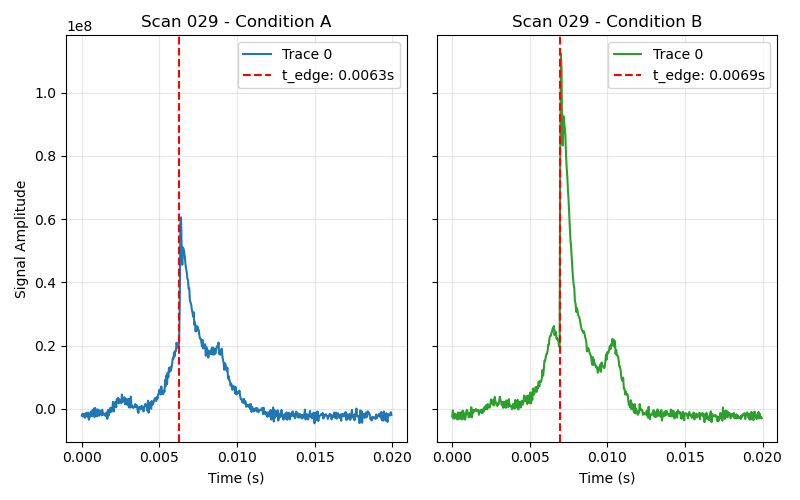

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_scan_data(file_index, trace_index=0, data_dir='.'):
    """
    Plots the detector trace for a given file index and trace index.
    
    Args:
        file_index (int): The index of the file (e.g., 0 for scan_000.npz).
        trace_index (int): The index of the trace to plot (0 to 49). Default is 0.
        data_dir (str): Directory containing the .npz files.
    """
    filename = f"scan_{file_index:03d}.npz"
    filepath = os.path.join(data_dir, filename)
    
    # Check if file exists
    if not os.path.exists(filepath):
        print(f"Error: File {filepath} not found.")
        return

    # Load Data
    try:
        data = np.load(filepath)
        time = data['time']
        
        # Extract the specific trace
        sig_a = data['signals_a'][trace_index]
        sig_b = data['signals_b'][trace_index]
        
        # Extract edge times (scalars)
        t_edge_a = float(data['t_edge_a'])
        t_edge_b = float(data['t_edge_b'])
        
        # --- Plotting ---
        fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
        
        # Condition A
        axes[0].plot(time, sig_a, color='#1f77b4', label=f'Trace {trace_index}')
        axes[0].axvline(t_edge_a, color='red', linestyle='--', label=f't_edge: {t_edge_a:.4f}s')
        axes[0].set_title(f"Scan {file_index:03d} - Condition A")
        axes[0].set_xlabel("Time (s)")
        axes[0].set_ylabel("Signal Amplitude")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Condition B
        axes[1].plot(time, sig_b, color='#2ca02c', label=f'Trace {trace_index}')
        axes[1].axvline(t_edge_b, color='red', linestyle='--', label=f't_edge: {t_edge_b:.4f}s')
        axes[1].set_title(f"Scan {file_index:03d} - Condition B")
        axes[1].set_xlabel("Time (s)")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

# Example Usage:
plot_scan_data(29, data_dir = "data")  # Plots scan_000.npz, trace 0

### per-file cloud

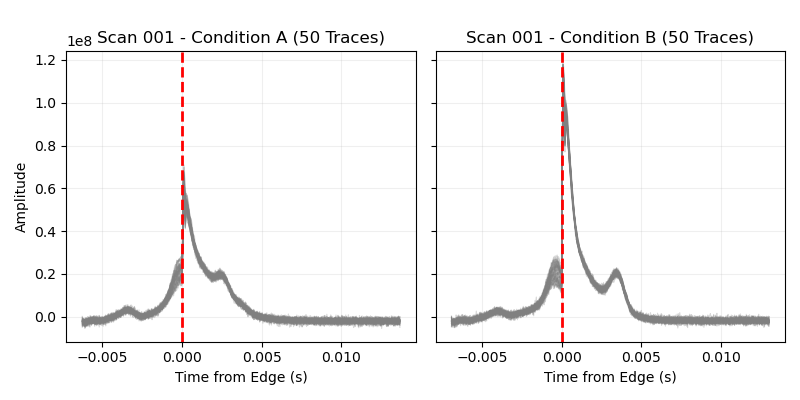

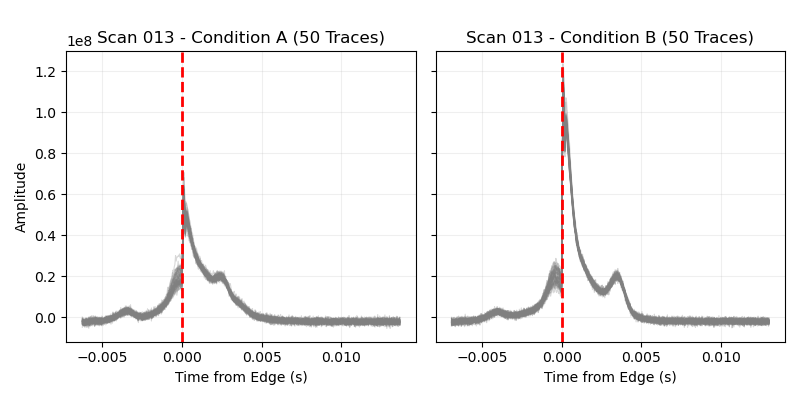

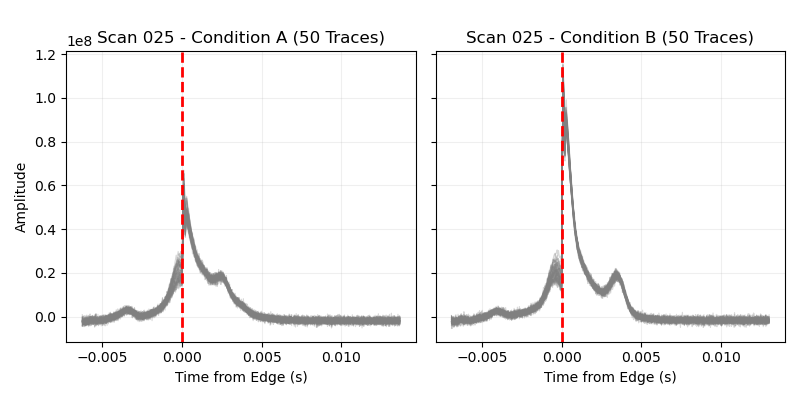

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_aligned_traces(file_index, data_dir='data'):
    """
    Plots all 50 traces for Condition A and B, aligned to t_edge = 0.
    
    Args:
        file_index (int): The index of the file (e.g., 0 for scan_000.npz).
        data_dir (str): Directory containing the .npz files.
    """
    filename = f"scan_{file_index:03d}.npz"
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"Error: File {filepath} not found.")
        return

    # Load Data
    data = np.load(filepath)
    time = data['time']
    signals_a = data['signals_a']  # Shape (50, 488)
    signals_b = data['signals_b']  # Shape (50, 488)
    t_edge_a = float(data['t_edge_a'])
    t_edge_b = float(data['t_edge_b'])
    
    # Create Aligned Time Axes
    # Shift time so that t_edge becomes 0
    t_aligned_a = time - t_edge_a
    t_aligned_b = time - t_edge_b
    
    # Setup Plot
    fig, axes = plt.subplots(1, 2, figsize=(8, 4
                                            
                                            ), sharey=True)
    
    # --- Plot Condition A ---
    # Note: plotting (N, 50) allows matplotlib to handle all lines at once efficiently
    axes[0].plot(t_aligned_a, signals_a.T, color='grey', alpha=0.3, linewidth=0.8)
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='t_edge (aligned)')
    
    axes[0].set_title(f"Scan {file_index:03d} - Condition A (50 Traces)")
    axes[0].set_xlabel("Time from Edge (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True, alpha=0.2)
    
    # --- Plot Condition B ---
    axes[1].plot(t_aligned_b, signals_b.T, color='grey', alpha=0.3, linewidth=0.8)
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='t_edge (aligned)')
    
    axes[1].set_title(f"Scan {file_index:03d} - Condition B (50 Traces)")
    axes[1].set_xlabel("Time from Edge (s)")
    axes[1].grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()

# Example Usage
plot_aligned_traces(1)
plot_aligned_traces(13)
plot_aligned_traces(25)

## Filtering 

## Synthetic 

Simulation complete. The plot shows that 3 Gaussians can indeed form this shape.


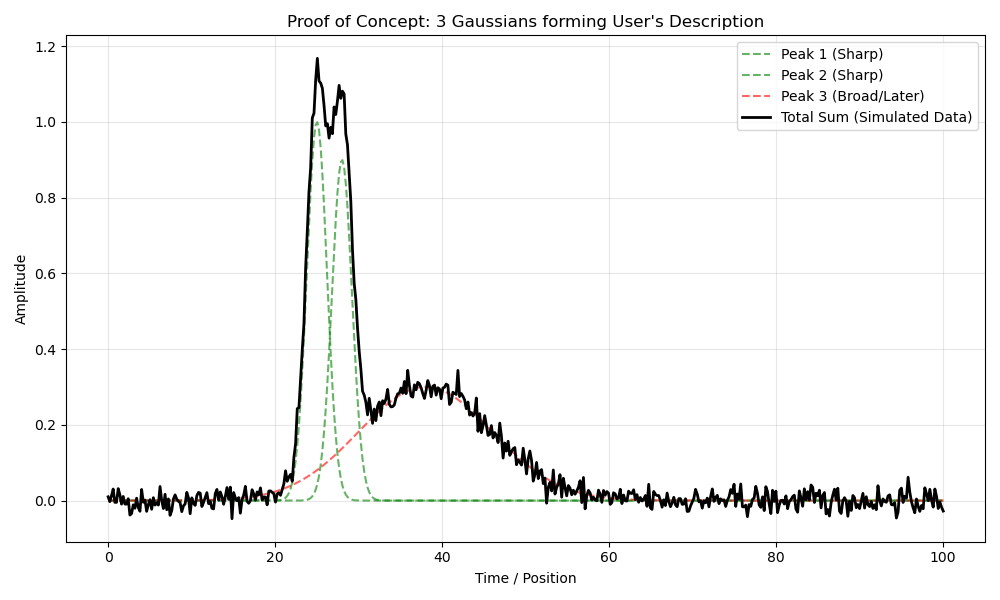

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    """
    Basic Gaussian function: A * exp(-(x - mu)^2 / (2 * sigma^2))
    """
    return amp * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

def three_gaussians(x, *params):
    """
    Sum of three Gaussian functions.
    params: [amp1, mu1, sigma1, amp2, mu2, sigma2, amp3, mu3, sigma3]
    """
    g1 = gaussian(x, params[0], params[1], params[2])
    g2 = gaussian(x, params[3], params[4], params[5])
    g3 = gaussian(x, params[6], params[7], params[8])
    return g1 + g2 + g3

# 1. Setup the X-axis (time or spatial domain)
x = np.linspace(0, 100, 500)

# 2. Define parameters for the "Theoretical" shape you described
# Region 2 after t_edge: 
# - Two sharp peaks close together
# - One shallow (wide) peak later

# Peak 1 (Sharp)
a1, mu1, sig1 = 1.0, 25.0, 1.2  # Sigma=1.2 is narrow/sharp
# Peak 2 (Sharp, close to Peak 1)
a2, mu2, sig2 = 0.9, 28.0, 1.2  # Close mu (25 vs 30), same sharpness
# Peak 3 (Soft/Shallow, later in signal)
a3, mu3, sig3 = 0.3, 38.0, 8.0  # Sigma=8.0 is wide/soft

# 3. Generate the signal
y_ground_truth = three_gaussians(x, a1, mu1, sig1, a2, mu2, sig2, a3, mu3, sig3)

# Add a little noise to make it realistic
np.random.seed(42)
noise = np.random.normal(0, 0.02, x.size)
y_noisy = y_ground_truth + noise

# 4. Visualization
plt.figure(figsize=(10, 6))

# Plot the individual components to show how they sum up
plt.plot(x, gaussian(x, a1, mu1, sig1), 'g--', alpha=0.6, label='Peak 1 (Sharp)')
plt.plot(x, gaussian(x, a2, mu2, sig2), 'g--', alpha=0.6, label='Peak 2 (Sharp)')
plt.plot(x, gaussian(x, a3, mu3, sig3), 'r--', alpha=0.6, label='Peak 3 (Broad/Later)')

# Plot the resulting sum
plt.plot(x, y_noisy, 'k-', linewidth=2, label='Total Sum (Simulated Data)')

# Formatting
plt.title("Proof of Concept: 3 Gaussians forming User's Description")
plt.xlabel("Time / Position")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('gaussian_simulation.png')
print("Simulation complete. The plot shows that 3 Gaussians can indeed form this shape.")

Running fit on Region 2...

--- Fit Results (Region 2) ---
P1 (Target 25.0): Found Mu=22.19, Sig=2.80
P2 (Target 28.0): Found Mu=31.47, Sig=2.03
P3 (Target 38.0): Found Mu=37.38, Sig=5.79

Plot saved as 'gaussian_simulation.png'


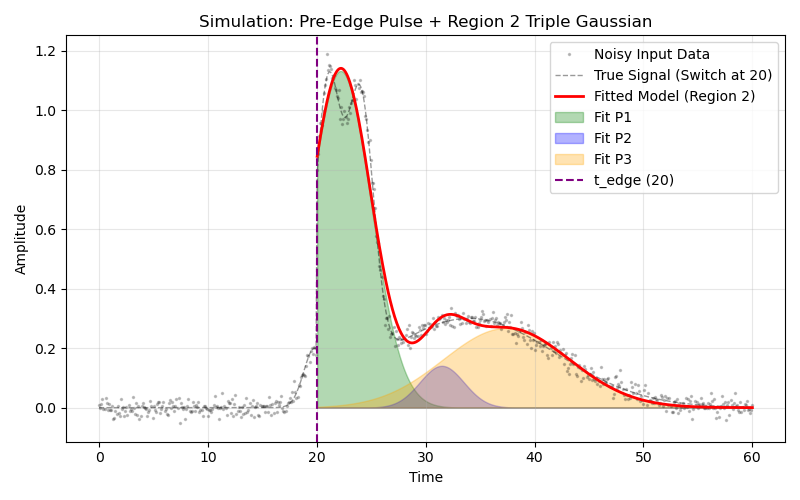

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Model Definitions ---

def gaussian(x, amp, mu, sigma):
    """
    Basic Gaussian function.
    """
    return amp * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

def three_gaussians(x, *params):
    """
    Sum of three Gaussian functions.
    params order: [amp1, mu1, sigma1, amp2, mu2, sigma2, amp3, mu3, sigma3]
    """
    g1 = gaussian(x, params[0], params[1], params[2])
    g2 = gaussian(x, params[3], params[4], params[5])
    g3 = gaussian(x, params[6], params[7], params[8])
    return g1 + g2 + g3

# --- 2. The Fitting Function (Optimized for the new Region 2) ---

def fit_region2_model(x_data, y_data):
    """
    Fits a sum of 3 Gaussians to the data (Region 2).
    """
    
    # INITIAL GUESSES (p0)
    # Updated to match the new structure (Peaks around 25, 28, 38)
    # We provide guesses fairly close to the truth to help the optimizer.
    p0 = [
        0.8, 24.0, 1.0,  # Peak 1 (Guess near 25)
        0.8, 29.0, 1.0,  # Peak 2 (Guess near 28)
        0.3, 40.0, 5.0   # Peak 3 (Guess near 38, broad)
    ]

    # BOUNDS (lower, upper)
    # Constrain widths to separate the two sharp peaks.
    # We keep sigma1 and sigma2 tightly bounded (< 3.0) so they don't merge.
    lower_bounds = [0,   20,  0.1,   0,   20,  0.1,   0,   30,  2.0]
    upper_bounds = [3,   30,  3.0,   3,   35,  3.0,   3,   60,  20.0]
    
    try:
        popt, pcov = curve_fit(
            three_gaussians, 
            x_data, 
            y_data, 
            p0=p0, 
            bounds=(lower_bounds, upper_bounds),
            maxfev=5000
        )
        return popt
    except RuntimeError:
        print("Fit failed to converge.")
        return None

# --- 3. Generate Synthetic Data (Full Signal Simulation) ---

# X-axis covering pre-edge and post-edge
x = np.linspace(0, 60, 600)
t_edge = 20.0

# -- Part A: Pre-Edge Signal (Single Gaussian) --
# Tunable mu at around 19
params_pre = [0.2, 19.8, 1.0] 

# -- Part B: Post-Edge Signal (Triple Gaussian) --
# Parameters from your request
# Peak 1 (Sharp): 1.0, 25.0, 1.2
# Peak 2 (Sharp): 0.9, 28.0, 1.2
# Peak 3 (Soft):  0.3, 38.0, 8.0
params_post = [
    1.0, 25.0-4, 1.2,
    0.9, 28.0-4, 1.2,
    0.3, 38.0-4, 8.0
]

# Construct the full signal with a "Switch" at t_edge
y_pre_clean = gaussian(x, *params_pre)
y_post_clean = three_gaussians(x, *params_post)

# Combine: Use Pre-model before t_edge, Post-model after
y_ground_truth = np.where(x < t_edge, y_pre_clean, y_post_clean)

# Add noise
np.random.seed(42)
noise = np.random.normal(0, 0.02, x.size)
y_noisy = y_ground_truth + noise

# --- 4. Run the Fit (Only on Region 2) ---

# We only want to fit the data AFTER t_edge (Region 2)
mask_region2 = x >= t_edge
x_r2 = x[mask_region2]
y_r2_noisy = y_noisy[mask_region2]

print("Running fit on Region 2...")
fitted_params = fit_region2_model(x_r2, y_r2_noisy)

# --- 5. Visualization ---
plt.figure(figsize=(8, 5))

# Plot 1: The Full Noisy Signal
plt.plot(x, y_noisy, 'k.', alpha=0.2, label='Noisy Input Data', markersize=3)

# Plot 2: The Underlying "Switch" Model
plt.plot(x, y_ground_truth, 'k--', alpha=0.4, label='True Signal (Switch at 20)', linewidth=1)

# Plot 3: The Fitted Model (Region 2 Only)
if fitted_params is not None:
    y_fit_r2 = three_gaussians(x_r2, *fitted_params)
    plt.plot(x_r2, y_fit_r2, 'r-', label='Fitted Model (Region 2)', linewidth=2)

    # Decompose the fitted peaks
    p = fitted_params
    plt.fill_between(x_r2, gaussian(x_r2, p[0], p[1], p[2]), alpha=0.3, color='green', label='Fit P1')
    plt.fill_between(x_r2, gaussian(x_r2, p[3], p[4], p[5]), alpha=0.3, color='blue', label='Fit P2')
    plt.fill_between(x_r2, gaussian(x_r2, p[6], p[7], p[8]), alpha=0.3, color='orange', label='Fit P3')

    print("\n--- Fit Results (Region 2) ---")
    print(f"P1 (Target 25.0): Found Mu={p[1]:.2f}, Sig={p[2]:.2f}")
    print(f"P2 (Target 28.0): Found Mu={p[4]:.2f}, Sig={p[5]:.2f}")
    print(f"P3 (Target 38.0): Found Mu={p[7]:.2f}, Sig={p[8]:.2f}")
else:
    print("Fit failed.")

# Formatting
plt.axvline(t_edge, color='purple', linestyle='--', linewidth=1.5, label='t_edge (20)')
plt.title("Simulation: Pre-Edge Pulse + Region 2 Triple Gaussian")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('gaussian_simulation.png')
print("\nPlot saved as 'gaussian_simulation.png'")
plt.show()

Running fit on Region 2...

--- Fit Results (Region 2) ---
P1 (Target 25.0): Found Mu=24.00, Sig=1.00
P2 (Target 28.0): Found Mu=29.00, Sig=1.00
P3 (Target 38.0): Found Mu=40.00, Sig=5.00

Plot saved as 'gaussian_simulation.png'


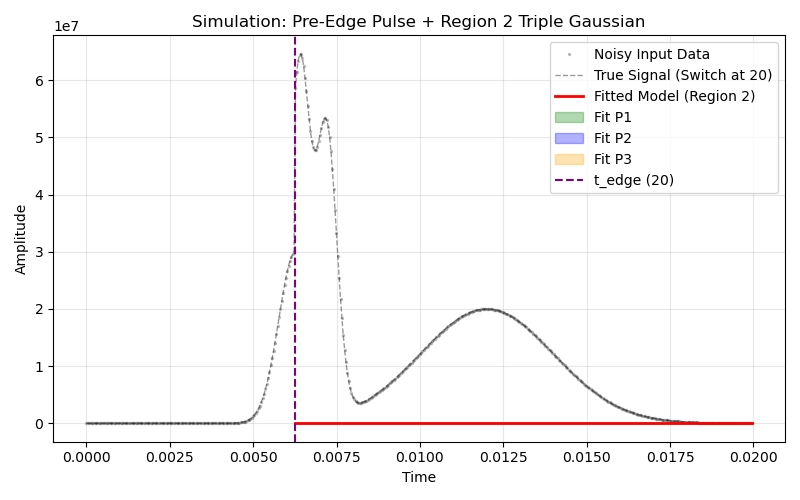

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Model Definitions ---

def gaussian(x, amp, mu, sigma):
    """
    Basic Gaussian function.
    """
    return amp * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

def three_gaussians(x, *params):
    """
    Sum of three Gaussian functions.
    params order: [amp1, mu1, sigma1, amp2, mu2, sigma2, amp3, mu3, sigma3]
    """
    g1 = gaussian(x, params[0], params[1], params[2])
    g2 = gaussian(x, params[3], params[4], params[5])
    g3 = gaussian(x, params[6], params[7], params[8])
    return g1 + g2 + g3

# --- 2. The Fitting Function (Optimized for the new Region 2) ---

def fit_region2_model(x_data, y_data):
    """
    Fits a sum of 3 Gaussians to the data (Region 2).
    """
    
    # INITIAL GUESSES (p0)
    # Updated to match the new structure (Peaks around 25, 28, 38)
    # We provide guesses fairly close to the truth to help the optimizer.
    p0 = [
        0.8, 24.0, 1.0,  # Peak 1 (Guess near 25)
        0.8, 29.0, 1.0,  # Peak 2 (Guess near 28)
        0.3, 40.0, 5.0   # Peak 3 (Guess near 38, broad)
    ]

    # BOUNDS (lower, upper)
    # Constrain widths to separate the two sharp peaks.
    # We keep sigma1 and sigma2 tightly bounded (< 3.0) so they don't merge.
    lower_bounds = [0,   20,  0.1,   0,   20,  0.1,   0,   30,  2.0]
    upper_bounds = [3,   30,  3.0,   3,   35,  3.0,   3,   60,  20.0]
    
    try:
        popt, pcov = curve_fit(
            three_gaussians, 
            x_data, 
            y_data, 
            p0=p0, 
            bounds=(lower_bounds, upper_bounds),
            maxfev=5000
        )
        return popt
    except RuntimeError:
        print("Fit failed to converge.")
        return None

# --- 3. Generate Synthetic Data (Full Signal Simulation) ---

# --- 2. Configuration (Based on scan_000.npz inspection) ---

# Time Axis: Matches your file (0 to ~0.02s)
x = np.linspace(0.000000, 0.019948, 488)

d_t = 0.019948/488

# t_edge: The transition point found in your data
t_edge = 0.006267

# --- 3. Define the Physics Parameters ---

# Part A: Pre-Edge Signal (Single Pulse before the edge)
# Placing it slightly before t_edge (e.g., at 5ms)
params_pre = [
    3.0e7,      # Amplitude (Approx matching max signal)
    t_edge,     # mu (5ms)
    0.0005      # sigma (Broad-ish)
]

# Part B: Post-Edge Signal (The 3-Peak "Cloud Scan" signature)
# Based on your inspection: 
# - Max Peak found at 0.006390 (Just 0.12ms after edge!)
# - Width approx 0.0008 -> Sigma approx 0.00035
params_post = [
    # Peak 1: The Main Sharp Peak (Aligned with your data)
    6.25e7,     # Amp (From inspection)
    0.006390,   # Mu (Exact peak time from inspection)
    0.00035-d_t,    # Sigma (Derived from 0.0008 width)

    # Peak 2: Second Sharp Peak (Hypothetical, close to P1)
    # Let's place it 0.8ms after P1
    5.0e7,      # Amp
    0.007200,   # Mu (0.0064 + 0.0008)
    0.00035-d_t,    # Sigma (Sharp)

    # Peak 3: Broad "Cloud" Peak (Later)
    # Let's place it further out at 12ms
    2.0e7,      # Amp (Lower)
    0.012000,   # Mu
    0.002000    # Sigma (Very Broad)
]
# Construct the full signal with a "Switch" at t_edge
y_pre_clean = gaussian(x, *params_pre)
y_post_clean = three_gaussians(x, *params_post)

# Combine: Use Pre-model before t_edge, Post-model after
y_ground_truth = np.where(x < t_edge, y_pre_clean, y_post_clean)

# Add noise
np.random.seed(42)
noise = np.random.normal(0, 0.02, x.size)
y_noisy = y_ground_truth + noise

# --- 4. Run the Fit (Only on Region 2) ---

# We only want to fit the data AFTER t_edge (Region 2)
mask_region2 = x >= t_edge
x_r2 = x[mask_region2]
y_r2_noisy = y_noisy[mask_region2]

print("Running fit on Region 2...")
fitted_params = fit_region2_model(x_r2, y_r2_noisy)

# --- 5. Visualization ---
plt.figure(figsize=(8, 5))

# Plot 1: The Full Noisy Signal
plt.plot(x, y_noisy, 'k.', alpha=0.2, label='Noisy Input Data', markersize=3)

# Plot 2: The Underlying "Switch" Model
plt.plot(x, y_ground_truth, 'k--', alpha=0.4, label='True Signal (Switch at 20)', linewidth=1)

# Plot 3: The Fitted Model (Region 2 Only)
if fitted_params is not None:
    y_fit_r2 = three_gaussians(x_r2, *fitted_params)
    plt.plot(x_r2, y_fit_r2, 'r-', label='Fitted Model (Region 2)', linewidth=2)

    # Decompose the fitted peaks
    p = fitted_params
    plt.fill_between(x_r2, gaussian(x_r2, p[0], p[1], p[2]), alpha=0.3, color='green', label='Fit P1')
    plt.fill_between(x_r2, gaussian(x_r2, p[3], p[4], p[5]), alpha=0.3, color='blue', label='Fit P2')
    plt.fill_between(x_r2, gaussian(x_r2, p[6], p[7], p[8]), alpha=0.3, color='orange', label='Fit P3')

    print("\n--- Fit Results (Region 2) ---")
    print(f"P1 (Target 25.0): Found Mu={p[1]:.2f}, Sig={p[2]:.2f}")
    print(f"P2 (Target 28.0): Found Mu={p[4]:.2f}, Sig={p[5]:.2f}")
    print(f"P3 (Target 38.0): Found Mu={p[7]:.2f}, Sig={p[8]:.2f}")
else:
    print("Fit failed.")

# Formatting
plt.axvline(t_edge, color='purple', linestyle='--', linewidth=1.5, label='t_edge (20)')
plt.title("Simulation: Pre-Edge Pulse + Region 2 Triple Gaussian")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('gaussian_simulation.png')
print("\nPlot saved as 'gaussian_simulation.png'")
plt.show()

Initializing SignalProcessor (Triple Model)...
Running fit on synthetic data...


/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/1753801199.py:231: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)
/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/1753801199.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)


Fit Successful!

--- PARAMETER RECOVERY ---
P1 Pos: 0.006405 (Target: 0.006390) | Error: 0.000015
P2 Pos: 0.007183 (Target: 0.007200) | Error: 0.000017
Plot saved to 'processor_validation.png'


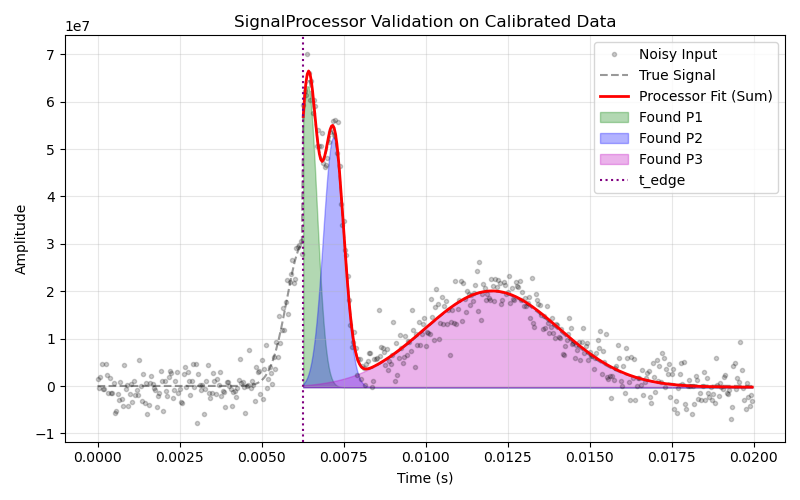

In [162]:

# ==========================================
# 2. GENERATE CALIBRATED DATA
# ==========================================

# Time Axis (0 to ~0.02s)
x = np.linspace(0.000000, 0.019948, 488)
t_edge = 0.006267
d_t = 0.019948/488

# Physics Parameters (Calibrated)
# Pre-Edge (Pulse before edge)
params_pre = [3.0e7, t_edge, 0.0005] # Amp, Mu, Sigma

# Post-Edge (Triple Peak)
params_post = [
    6.25e7, 0.006390, 0.00035 - d_t,   # P1 (Sharp)
    5.0e7,  0.007200, 0.00035 - d_t,   # P2 (Sharp)
    2.0e7,  0.012000, 0.002000         # P3 (Broad)
]

def gaussian_func(t, A, mu, sigma): return A * np.exp(-(t - mu) ** 2 / (2 * sigma ** 2))
def triple_func(t, *p): 
    return (gaussian_func(t, p[0], p[1], p[2]) + 
            gaussian_func(t, p[3], p[4], p[5]) + 
            gaussian_func(t, p[6], p[7], p[8]))

# Construct Signal
y_pre = gaussian_func(x, *params_pre)
y_post = triple_func(x, *params_post)
y_clean = np.where(x < t_edge, y_pre, y_post)

# Add Noise
np.random.seed(42)
noise = np.random.normal(0, 3.0e6, x.size)
y_noisy = y_clean + noise


# ==========================================
# 3. RUN PROCESSOR FIT
# ==========================================

print("Initializing SignalProcessor (Triple Model)...")
processor = SignalProcessor(region2_model='triple', multi_pulse_return_mode='sum')

print("Running fit on synthetic data...")
# Note: we pass the full signal; the processor handles splitting at t_edge
result = processor.run(x, y_noisy, t_edge)

# ==========================================
# 4. VISUALIZATION
# ==========================================

r2_res = result['region2']
if r2_res['success']:
    print("Fit Successful!")
    p = r2_res['params']
    
    # Extract Region 2 x-axis for plotting
    mask = x >= t_edge
    x_r2 = x[mask]
    
    plt.figure(figsize=(8, 5))
    
    # 1. Data
    plt.plot(x, y_noisy, 'k.', alpha=0.2, label='Noisy Input')
    plt.plot(x, y_clean, 'k--', alpha=0.4, label='True Signal')
    
    # 2. Processor Fit (Sum)
    # Note: params includes C at the end
    y_fit_sum = processor._multi_gaussian_3(x_r2, *p)
    plt.plot(x_r2, y_fit_sum, 'r-', linewidth=2, label='Processor Fit (Sum)')
    
    # 3. Decomposed Components (for verification)
    # Reconstruct individual pulses using the fitted parameters
    C = p[9]
    y_p1 = processor._gaussian(x_r2, p[0], p[1], p[2], C) # Plot with C base
    y_p2 = processor._gaussian(x_r2, p[3], p[4], p[5], C)
    y_p3 = processor._gaussian(x_r2, p[6], p[7], p[8], C)
    
    # Fill areas (subtracting C for visual clarity of pulse area)
    plt.fill_between(x_r2, y_p1, C, color='g', alpha=0.3, label='Found P1')
    plt.fill_between(x_r2, y_p2, C, color='b', alpha=0.3, label='Found P2')
    plt.fill_between(x_r2, y_p3, C, color='m', alpha=0.3, label='Found P3')
    
    # Print numerical comparison
    print("\n--- PARAMETER RECOVERY ---")
    print(f"P1 Pos: {p[1]:.6f} (Target: {params_post[1]:.6f}) | Error: {abs(p[1]-params_post[1]):.6f}")
    print(f"P2 Pos: {p[4]:.6f} (Target: {params_post[4]:.6f}) | Error: {abs(p[4]-params_post[4]):.6f}")
    
    plt.axvline(t_edge, color='purple', linestyle=':', label='t_edge')
    plt.title("SignalProcessor Validation on Calibrated Data")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('processor_validation.png')
    print("Plot saved to 'processor_validation.png'")
    plt.show()

else:
    print("Fit Failed.")

The following is a function to synthesize a signal for every ratio:


Calibrated Post-Pulse Max Amplitude: 6.47e+07
Starting loop: 50 iterations, Phase=2.353 rad...


/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/119945204.py:231: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)
/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/119945204.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)


Plot saved to 'phase_verification_plot.png'


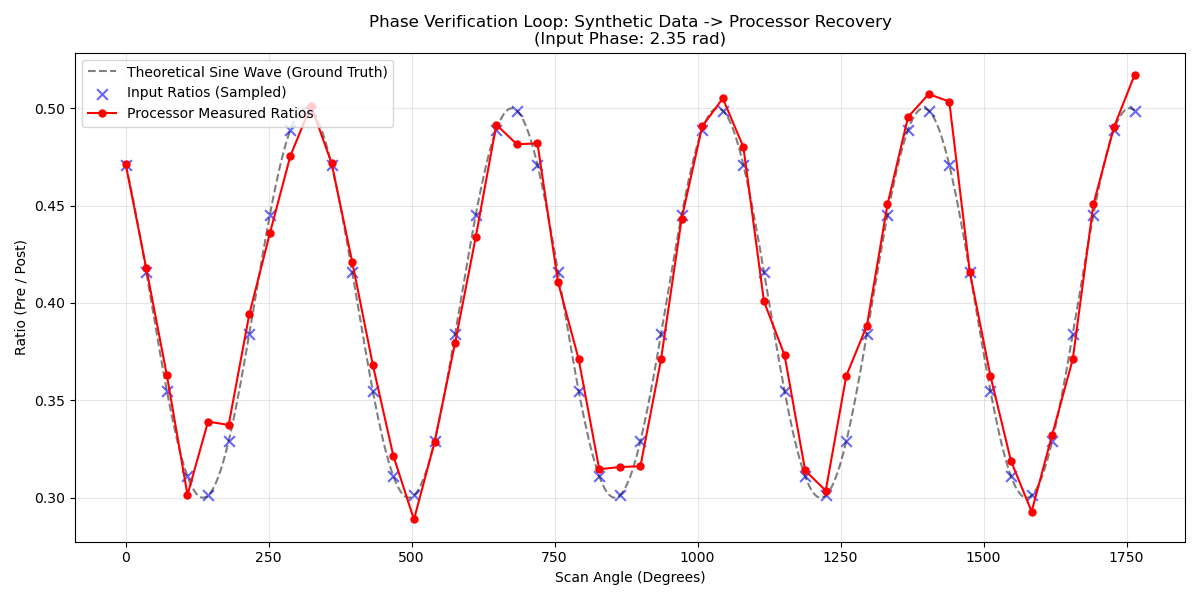

In [ ]:

# ==========================================
# 2. DATA GENERATION UTILITIES
# ==========================================

def get_calibrated_axis():
    # Time Axis (0 to ~0.02s) derived from scan_000.npz
    return np.linspace(0.000000, 0.019948, 488)

def generate_calibrated_trace(params_pre, params_post, noise_level=1.0e6, seed=None):
    """
    Generates a single synthetic trace based on calibrated physics parameters.
    Returns: (time_axis, signal_noisy, t_edge)
    """
    x = get_calibrated_axis()
    t_edge = 0.006267
    
    # Helper Gaussian functions
    def gaussian_func(t, A, mu, sigma): 
        return A * np.exp(-(t - mu) ** 2 / (2 * sigma ** 2))
    
    def triple_func(t, *p): 
        return (gaussian_func(t, p[0], p[1], p[2]) + 
                gaussian_func(t, p[3], p[4], p[5]) + 
                gaussian_func(t, p[6], p[7], p[8]))

    # Construct Signal
    y_pre = gaussian_func(x, *params_pre)
    y_post = triple_func(x, *params_post)
    
    # Switch at t_edge
    y_clean = np.where(x < t_edge, y_pre, y_post)

    # Add Noise
    if seed is not None:
        np.random.seed(seed)
    
    noise = np.random.normal(0, noise_level, x.size)
    y_noisy = y_clean + noise
    
    return x, y_noisy, t_edge

# ==========================================
# 3. PHASE LOOP VERIFICATION
# ==========================================

def run_phase_verification():
    # --- A. Setup Static Parameters (Post-Edge is constant) ---
    x_axis = get_calibrated_axis()
    t_edge_fixed = 0.006267
    d_t = 0.019948/488

    # Fixed Post-Edge (Triple Peak) parameters
    # P1: 6.25e7, P2: 5.0e7, P3: 2.0e7
    params_post_fixed = [
        6.25e7, 0.006390, 0.00035 - d_t,   # P1 (Sharp)
        5.0e7,  0.007200, 0.00035 - d_t,   # P2 (Sharp)
        2.0e7,  0.012000, 0.002000         # P3 (Broad)
    ]
    
    # Calculate the exact max amplitude of the post-pulse for accurate ratio targeting
    # (Since pulses might overlap slightly, the max is roughly P1 amp but let's be precise)
    def triple_func_temp(t, *p):
        def g(t, A, m, s): return A * np.exp(-(t - m)**2 / (2*s**2))
        return g(t, p[0], p[1], p[2]) + g(t, p[3], p[4], p[5]) + g(t, p[6], p[7], p[8])
    
    # We evaluate on a dense grid near peaks to find the true max
    t_check = np.linspace(0.006, 0.015, 1000)
    y_post_check = triple_func_temp(t_check, *params_post_fixed)
    amp_post_actual = np.max(y_post_check)
    print(f"Calibrated Post-Pulse Max Amplitude: {amp_post_actual:.2e}")

    # --- B. Sine Wave Model Setup ---
    np.random.seed(42)
    phi_true = np.random.uniform(0, 2*np.pi)
    
    target_A = 0.1
    target_C = 0.4
    
    def sine_model(x_deg, A, phi, C):
        return C + A * np.sin(np.deg2rad(x_deg) + phi)

    # --- C. The Loop ---
    n_steps = 50
    step_deg = 36.0
    
    scan_angles = []
    target_ratios = []
    measured_ratios = []
    
    # Initialize Processor (using 'sum' mode for Region 2 to capture full peak height)
    processor = SignalProcessor(region2_model='triple', multi_pulse_return_mode='sum')
    
    print(f"Starting loop: {n_steps} iterations, Phase={phi_true:.3f} rad...")

    for i in range(n_steps):
        # Step 4: Advance angle
        angle = i * step_deg
        
        # Step 5: Sample Sine Wave -> Target Ratio
        ratio_target = sine_model(angle, target_A, phi_true, target_C)
        
        # Step 6: Generate Params
        # We need Ratio = Amp_Pre / Amp_Post
        # So Amp_Pre = Ratio * Amp_Post
        amp_pre_needed = ratio_target * amp_post_actual
        
        # params_pre = [Amp, Mu, Sigma]
        # We keep Mu and Sigma fixed as per calibration
        current_params_pre = [amp_pre_needed, t_edge_fixed, 0.0005]
        
        # Step 7: Synthesize Data
        # We use i as seed component to vary noise slightly per trace
        time, signal, t_edge = generate_calibrated_trace(
            current_params_pre, 
            params_post_fixed, 
            seed=42+i
        )
        
        # Step 8: Run Processor
        res = processor.run(time, signal, t_edge)
        
        # Step 9: Extract & Save Ratio
        # Check if fit succeeded
        if res['region1']['success'] and res['region2']['success']:
            r_val = res['ratio']
        else:
            r_val = np.nan
            
        scan_angles.append(angle)
        target_ratios.append(ratio_target)
        measured_ratios.append(r_val)

    # --- D. Plotting ---
    plt.figure(figsize=(8, 4))
    
    # Convert lists to arrays
    scan_angles = np.array(scan_angles)
    target_ratios = np.array(target_ratios)
    measured_ratios = np.array(measured_ratios)
    
    # 1. Theoretical Sine Wave (Continuous for visual reference)
    dense_angles = np.linspace(0, max(scan_angles), 500)
    plt.plot(dense_angles, sine_model(dense_angles, target_A, phi_true, target_C), 
             'k--', alpha=0.5, label='Theoretical Sine Wave (Ground Truth)')
    
    # 2. The Target Points (Input to simulation)
    plt.scatter(scan_angles, target_ratios, c='blue', marker='x', s=60, alpha=0.6, label='Input Ratios (Sampled)')
    
    # 3. The Recovered Points (Output from Processor)
    plt.plot(scan_angles, measured_ratios, 'r-o', linewidth=1.5, markersize=5, label='Processor Measured Ratios')
    
    plt.title(f"Phase Verification Loop: Synthetic Data -> Processor Recovery\n(Input Phase: {phi_true:.2f} rad)")
    plt.xlabel("Scan Angle (Degrees)")
    plt.ylabel("Ratio (Pre / Post)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('phase_verification_plot.png')
    print("Plot saved to 'phase_verification_plot.png'")
    plt.show()

if __name__ == "__main__":
    run_phase_verification()

In [121]:
# --- D. Fringe Analysis (Phase Extraction) ---
print("\nRunning Fringe Analysis on Extracted Ratios...")
fitter = FringeAnalyzer()

scan_angles = np.array(scan_angles)
measured_ratios = np.array(measured_ratios)
measured_uncertainties = np.array(measured_uncertainties)

fit_res = fitter.fit(scan_angles, measured_ratios, measured_uncertainties)

if fit_res:
    phi_rec = fit_res['phase_rad']
    # Normalize phases to 0-2pi for easier reading
    phi_true_norm = phi_true % (2*np.pi)
    phi_rec_norm = phi_rec % (2*np.pi)
    
    print("\n" + "="*40)
    print(" PHASE RECOVERY RESULTS")
    print("="*40)
    print(f"True Phase Input:      {phi_true:.4f} rad ({np.degrees(phi_true):.1f} deg)")
    print(f"Recovered Phase:       {phi_rec:.4f} rad ({np.degrees(phi_rec):.1f} deg)")
    print(f"Diff (True - Rec):     {phi_true - phi_rec:.4f} rad")
    print(f"Fitted Amplitude:      {fit_res['amplitude']:.4f} (Target: {target_A})")
    print(f"Fitted Offset:         {fit_res['offset']:.4f} (Target: {target_C})")
    print("="*40 + "\n")
else:
    print("Fringe Fit Failed!")



Running Fringe Analysis on Extracted Ratios...


NameError: name 'scan_angles' is not defined

## Fit

Signal processor class will utlimately reside in `src/` folder

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

class SignalProcessor:
    def __init__(self, region2_model='single', multi_pulse_return_mode='first', fit_window=None):
        """
        Initialize the processor.
        """
        self.region2_model = region2_model
        self.multi_pulse_return_mode = multi_pulse_return_mode
        self.fit_window = fit_window

    # --- MODELS ---
    def _gaussian(self, t, A, mu, sigma, C):
        return A * np.exp(-(t - mu)**2 / (2 * sigma**2)) + C

    def _multi_gaussian_2(self, t, *params):
        A1, mu1, s1, A2, mu2, s2, C = params
        return (A1 * np.exp(-(t - mu1)**2 / (2 * s1**2)) + 
                A2 * np.exp(-(t - mu2)**2 / (2 * s2**2)) + C)

    def _multi_gaussian_3(self, t, *params):
        A1, mu1, s1, A2, mu2, s2, A3, mu3, s3, C = params
        return (A1 * np.exp(-(t - mu1)**2 / (2 * s1**2)) + 
                A2 * np.exp(-(t - mu2)**2 / (2 * s2**2)) + 
                A3 * np.exp(-(t - mu3)**2 / (2 * s3**2)) + C)

    # --- HELPERS ---
    def _calculate_r2(self, y_true, y_pred):
        """Calculates the Coefficient of Determination (R^2)."""
        residuals = y_true - y_pred
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        
        if ss_tot == 0: return np.nan
        return 1 - (ss_res / ss_tot)

    def _sort_pulses(self, popt, n_pulses):
        pulses = []
        for i in range(n_pulses):
            base = i * 3
            pulses.append({
                'A': popt[base], 'mu': popt[base+1], 'sigma': popt[base+2], 'idx': base
            })
        pulses.sort(key=lambda x: x['mu'])
        return pulses[0]

    def _get_sum_peak(self, time, popt, model_func):
        fitted_curve = model_func(time, *popt)
        C = popt[-1]
        return np.max(fitted_curve) - C

    def _calculate_sum_peak_uncertainty_mc(self, time, popt, pcov, model_func, n_samples=1000):
        """
        Estimates the uncertainty (std dev) of the sum peak using Monte Carlo simulation.
        Resamples parameters from the covariance matrix and recalculates the peak.
        """
        if pcov is None or np.isnan(pcov).any():
            return np.nan
        
        try:
            # Generate random parameter sets based on the fit's covariance
            rng = np.random.default_rng()
            # Draw n_samples of parameter sets
            samples = rng.multivariate_normal(popt, pcov, n_samples)
            
            peaks = []
            for sample_params in samples:
                # Re-calculate peak for each synthetic parameter set
                # Uses the same logic as _get_sum_peak
                peak_val = self._get_sum_peak(time, sample_params, model_func)
                peaks.append(peak_val)
            
            # The uncertainty is the standard deviation of these simulated peaks
            return np.std(peaks)
        except Exception:
            return np.nan

    def _get_empty_result(self):
        return { 
            'amplitude': np.nan, 'uncertainty': np.nan, 
            'params': None, 'cov': None, 'success': False, 
            'r_squared': np.nan
        }

    # --- FITTING METHODS ---
    def get_amplitude_region1(self, time, signal):
        if len(time) < 5: return self._get_empty_result()
        try:
            # Guesses
            p0 = [
                np.max(signal) - np.min(signal),
                time[np.argmax(signal)],
                (time[-1] - time[0]) * 0.1,
                np.min(signal)
            ]
            bounds = ([0, time[0], 0, -np.inf], [np.inf, time[-1], np.inf, np.inf])
            
            popt, pcov = curve_fit(self._gaussian, time, signal, p0=p0, bounds=bounds, maxfev=2000)
            
            # Calculate R2 on the data passed to this function (windowed data)
            y_pred = self._gaussian(time, *popt)
            r2 = self._calculate_r2(signal, y_pred)

            return {
                'amplitude': popt[0],
                'uncertainty': np.sqrt(np.diag(pcov))[0],
                'params': popt,
                'success': True,
                'model': 'single',
                'r_squared': r2
            }
        except Exception:
            return self._get_empty_result()

    def get_amplitude_region2(self, time, signal, model=None):
        if len(time) < 5: return self._get_empty_result()
        if model is None: model = self.region2_model

        try:
            t_len = time[-1] - time[0]
            start = time[0]
            amp_guess = np.max(signal) - np.min(signal)
            offset_guess = np.min(signal)
            
            if model == 'single':
                return self.get_amplitude_region1(time, signal)

            elif model == 'double':
                p0 = [amp_guess, start + t_len*0.25, t_len*0.05,
                      amp_guess, start + t_len*0.5,  t_len*0.05, offset_guess]
                bounds = ([0, -np.inf, 0]*2 + [-np.inf], [np.inf, np.inf, np.inf]*2 + [np.inf])
                func, n_pulses = self._multi_gaussian_2, 2

            elif model == 'triple':
                p0 = [amp_guess, start + t_len*0.2, t_len*0.05,
                      amp_guess, start + t_len*0.4, t_len*0.05,
                      amp_guess, start + t_len*0.6, t_len*0.05, offset_guess]
                bounds = ([0, -np.inf, 0]*3 + [-np.inf], [np.inf, np.inf, np.inf]*3 + [np.inf])
                func, n_pulses = self._multi_gaussian_3, 3
            else:
                raise ValueError(f"Unknown model: {model}")

            popt, pcov = curve_fit(func, time, signal, p0=p0, bounds=bounds, maxfev=5000)

            # Calculate R2 on the fitted data
            y_pred = func(time, *popt)
            r2 = self._calculate_r2(signal, y_pred)

            if self.multi_pulse_return_mode == 'first':
                first_pulse = self._sort_pulses(popt, n_pulses)
                amp, err = first_pulse['A'], np.sqrt(np.diag(pcov))[first_pulse['idx']]
            elif self.multi_pulse_return_mode == 'sum':
                # Use Monte Carlo simulation to estimate uncertainty of the combined peak
                amp = self._get_sum_peak(time, popt, func)
                err = self._calculate_sum_peak_uncertainty_mc(time, popt, pcov, func)

            return {
                'amplitude': amp, 'uncertainty': err, 
                'params': popt, 'success': True, 
                'model': model, 'r_squared': r2
            }

        except Exception:
            return self._get_empty_result()

    # --- PIPELINE ---
    def run(self, time, signal, t_edge, region2_model=None, fit_window=None):
        if region2_model is None: region2_model = self.region2_model
        if fit_window is None: fit_window = self.fit_window

        split_idx = np.searchsorted(time, t_edge)
        t1_full, s1_full = time[:split_idx], signal[:split_idx]
        t2_full, s2_full = time[split_idx:], signal[split_idx:]
        
        # Apply Windowing
        if fit_window is not None:
            mask1 = t1_full >= (t_edge - fit_window)
            t1_fit, s1_fit = t1_full[mask1], s1_full[mask1]
            mask2 = t2_full <= (t_edge + fit_window)
            t2_fit, s2_fit = t2_full[mask2], s2_full[mask2]
        else:
            t1_fit, s1_fit = t1_full, s1_full
            t2_fit, s2_fit = t2_full, s2_full

        r1_res = self.get_amplitude_region1(t1_fit, s1_fit)
        r2_res = self.get_amplitude_region2(t2_fit, s2_fit, model=region2_model)
        
        ratio, ratio_err = np.nan, np.nan
        if r1_res['success'] and r2_res['success']:
            A1, A2 = r1_res['amplitude'], r2_res['amplitude']
            if A2 != 0:
                ratio = A1 / A2
                u1, u2 = r1_res['uncertainty'], r2_res['uncertainty']
                if not np.isnan(u1) and not np.isnan(u2):
                    ratio_err = abs(ratio) * np.sqrt((u1/A1)**2 + (u2/A2)**2)

        return {
            'ratio': ratio, 'ratio_uncertainty': ratio_err, 
            't_edge': t_edge, 'fit_window': fit_window,
            'region1': r1_res, 'region2': r2_res,
            'time': time, 'signal': signal
        }

    # --- VISUALIZATION ---
    def plot_result(self, res, ax=None):
        if ax is None: fig, ax = plt.subplots(figsize=(10, 6))
        
        time, signal, t_edge = res['time'], res['signal'], res['t_edge']
        fit_window = res.get('fit_window')
        
        ax.scatter(time, signal, color='lightgrey', s=10, label='Raw Signal')
        ax.axvline(t_edge, color='black', linestyle=':', label='t_edge')

        if fit_window is not None:
            ax.axvspan(time[0], t_edge - fit_window, color='red', alpha=0.05, label='Excluded')
            ax.axvspan(t_edge + fit_window, time[-1], color='red', alpha=0.05)

        t_dense = np.linspace(time[0], time[-1], 1000)

        # Plot Fits and Labels
        for region_key, color, label in [('region1', 'red', 'Pulse 1'), ('region2', 'blue', 'Pulse 2')]:
            r_res = res[region_key]
            if r_res['success']:
                if r_res['model'] == 'single': func = self._gaussian
                elif r_res['model'] == 'double': func = self._multi_gaussian_2
                elif r_res['model'] == 'triple': func = self._multi_gaussian_3
                
                y_fit = func(t_dense, *r_res['params'])
                
                if region_key == 'region1': active = t_dense <= t_edge
                else: active = t_dense >= t_edge
                
                # Add R2 to legend label
                r2_label = f"{label} ($R^2={r_res['r_squared']:.3f}$)"
                ax.plot(t_dense[active], y_fit[active], color=color, linewidth=2, label=r2_label)
                ax.plot(t_dense[~active], y_fit[~active], color=color, alpha=0.3, linestyle='--')
                
                if r_res['model'] == 'single':
                    peak_t = r_res['params'][1]
                    peak_val = r_res['params'][0] + r_res['params'][3]
                else:
                    peak_idx = np.argmax(y_fit)
                    peak_t, peak_val = t_dense[peak_idx], y_fit[peak_idx]
                ax.plot(peak_t, peak_val, marker='*', color=color, markersize=12, markeredgecolor='k')

        ax.set_title(f"Fit Result | Ratio: {res['ratio']:.4f}")
        ax.set_xlabel("Time (s)")
        ax.grid(True, alpha=0.3)
        ax.legend()
        return ax

Ratio: 0.3407
Region 2 Amp (Sum Peak): 48598281.7894
Region 1 Amp: 16556483.0504


/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/2554025955.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(popt, pcov, n_samples)


<Axes: title={'center': 'Fit Result | Ratio: 0.3407'}, xlabel='Time (s)'>

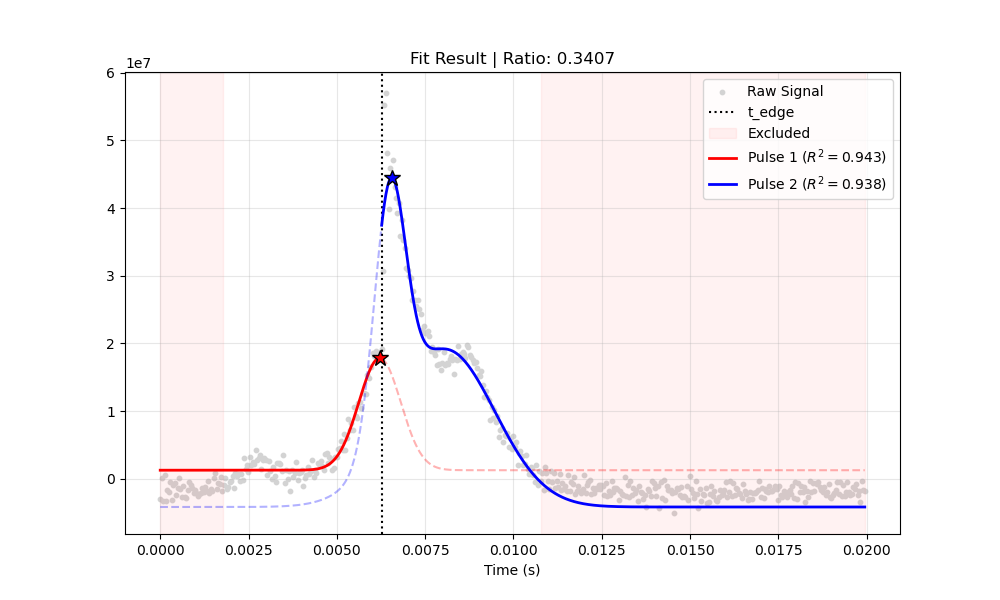

In [131]:

# --- SETTINGS ---
FILE_INDEX = 29    # e.g., scan_000.npz
TRACE_INDEX = 20   # 0 to 49
DATA_DIR = 'data' # Ensure this matches your folder name
# --- LOAD DATA ---
filename = f"scan_{FILE_INDEX:03d}.npz"
filepath = os.path.join(DATA_DIR, filename)

data = np.load(filepath)
time = data['time']

# Let's test on Condition A (you can swap to B easily)
signal = data['signals_a'][TRACE_INDEX]
t_edge = float(data['t_edge_a'])

# --- SPLIT REGIONS ---
split_idx = np.searchsorted(time, t_edge)

t1, s1 = time[:split_idx], signal[:split_idx]
t2, s2 = time[split_idx:], signal[split_idx:]

# Initialize: Choose 'sum' to get the peak of the combined pulses
processor = SignalProcessor(multi_pulse_return_mode='sum', fit_window=0.0045)

# Run everything in one line
results = processor.run(time, signal, t_edge, region2_model='double')

# Access data easily
print(f"Ratio: {results['ratio']:.4f}")
print(f"Region 2 Amp (Sum Peak): {results['region2']['amplitude']:.4f}")
print(f"Region 1 Amp: {results['region1']['amplitude']:.4f}")

processor.plot_result(results)

In [35]:
results['region1']

{'amplitude': np.float64(16556483.050378539),
 'uncertainty': np.float64(733422.1636903636),
 'params': array([1.65564831e+07, 6.21682045e-03, 5.92606577e-04, 1.29127858e+06]),
 'success': True,
 'model': 'single',
 'r_squared': np.float64(0.9431480803261089)}

## Fit Updated 1

I updated some of the earlier choices that Gemini had made to improve the results

***Decision***: define pulse amplitude as **A** rather than **A + C**

### Model
For Region 1 we fit a Gaussian-with-offset model

$$
\hat s(t) = A\,\exp\left(-\frac{(t-\mu)^2}{2\sigma^2}\right) + C
$$

where:
- **A** is the pulse height above baseline (pulse “gain” / signal component)
- **C** is a constant offset over the fit window (baseline / DC term)

### Why amplitude = A (above-baseline)
We define the Region‑1 pulse amplitude as **A** (not the absolute peak \(A+C\)) because the quantity of interest is the *pulse-induced change* in the sensor output, independent of any slowly varying offset.

Operationally, this means:
- **C** is treated as a **bias term** (baseline / DC offset) in the sensor reading over that window.
- The pulse amplitude should capture only the transient pulse component; that is exactly **A**.

This choice makes the amplitude estimate more stable and comparable across traces because it is less sensitive to baseline drift and offset differences between scans.

### Consequence
With this definition, the “pulse amplitude” uncertainty corresponds to the uncertainty of the fitted parameter **A** (i.e., \($\mathrm{SE}(\hat A)$\)), rather than the uncertainty of the absolute peak \($A+C$\). If absolute peak height were required, we would instead use \($A+C$\) and propagate uncertainty using \($\mathrm{Var}(A+C)=\mathrm{Var}(A)+\mathrm{Var}(C)+2\mathrm{Cov}(A,C)$\).



In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


class SignalProcessor:
    """Pulse-fitting + ratio pipeline.

    Key conventions used throughout:
    - Region 1 (single Gaussian): amplitude is A (height above baseline C).
    - Region 2:
        - 'single' returns Region-1 style amplitude = A.
        - 'first' returns amplitude = A of the earliest (by mu) Gaussian component.
        - 'sum' returns amplitude = max_t(sum of Gaussians) above baseline, i.e. max(model) - C.
    - Baseline C is treated as a bias (DC offset) term in the sensor reading.

    Notes on partial capture:
    - mu is allowed to be outside the local fit window by a controlled margin.
    - For the Region-2 'triple' model, we ALSO impose per-component mu/sigma bounds to
      encourage two narrow near-edge peaks + one later broader peak, matching the data shape.

    Notes on uncertainty:
    - For single/first modes: uncertainty is the standard error (SE) of the fitted amplitude parameter.
    - For sum mode: uncertainty is the Monte-Carlo std dev of the composite peak functional,
      sampling from the fitted parameter covariance (after PSD repair) and rejecting samples
      that violate the SAME bounds used in the fit.
    """

    def __init__(self, region2_model='single', multi_pulse_return_mode='first', fit_window=None):
        self.region2_model = region2_model
        self.multi_pulse_return_mode = multi_pulse_return_mode
        self.fit_window = fit_window

        # Allow mu to live outside the local fit window by a margin (supports partial capture)
        self.mu_margin_factor = 0.1  # allow mu half-window beyond each side

        # Used when computing a composite peak over an expanded grid
        self.sum_peak_grid_mult = 5  # densify peak search grid

        # Shape priors for Region-2 triple mode (tunable):
        # These are expressed as fractions of the local Region-2 time span and/or sample dt.
        # If your traces differ, tune these rather than loosening to +/- inf.
        self.r2_triple_near_mu_span_factor = 0.05   # mu1 span around edge: +/- 5% of window
        self.r2_triple_mu2_end_factor = 0.12        # mu2 allowed up to edge + 12% of window
        self.r2_triple_mu3_lo_factor = 0.10         # mu3 starts at edge + 10% of window
        self.r2_triple_mu3_hi_factor = 0.95         # mu3 ends at edge + 95% of window

        self.r2_triple_s1_hi_factor = 0.03          # sigma1 max: 3% of window (narrow)
        self.r2_triple_s2_hi_factor = 0.05          # sigma2 max: 5% of window (narrow)
        self.r2_triple_s3_hi_factor = 0.1          # sigma3 max: 35% of window (broader)

    # --- MODELS ---
    def _gaussian(self, t, A, mu, sigma, C):
        return A * np.exp(-(t - mu) ** 2 / (2 * sigma ** 2)) + C

    def _multi_gaussian_2(self, t, *params):
        A1, mu1, s1, A2, mu2, s2, C = params
        return (
            A1 * np.exp(-(t - mu1) ** 2 / (2 * s1 ** 2))
            + A2 * np.exp(-(t - mu2) ** 2 / (2 * s2 ** 2))
            + C
        )

    def _multi_gaussian_3(self, t, *params):
        A1, mu1, s1, A2, mu2, s2, A3, mu3, s3, C = params
        return (
            A1 * np.exp(-(t - mu1) ** 2 / (2 * s1 ** 2))
            + A2 * np.exp(-(t - mu2) ** 2 / (2 * s2 ** 2))
            + A3 * np.exp(-(t - mu3) ** 2 / (2 * s3 ** 2))
            + C
        )

    # --- HELPERS ---
    def _mu_bounds(self, time, margin_factor=0.1):
        """Expanded mu bounds to support partial capture.

        Returns (mu_lo, mu_hi) where mu may be outside the data window.
        """
        t0, t1 = float(time[0]), float(time[-1])
        t_len = t1 - t0
        delta = margin_factor * t_len
        return (t0 - delta, t1 + delta)

    def _calculate_r2(self, y_true, y_pred):
        """Coefficient of determination (R^2) for reporting."""
        residuals = y_true - y_pred
        ss_res = float(np.sum(residuals ** 2))
        ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
        if ss_tot == 0:
            return np.nan
        return 1.0 - (ss_res / ss_tot)

    def _sort_pulses(self, popt, n_pulses):
        """Sort by mu and return earliest pulse.

        NOTE: idx returned is the *parameter index* of that pulse's A in popt/pcov.
        """
        pulses = []
        for i in range(n_pulses):
            base = i * 3
            pulses.append({
                'A': popt[base],
                'mu': popt[base + 1],
                'sigma': popt[base + 2],
                'idx': base,
            })
        pulses.sort(key=lambda x: x['mu'])
        return pulses[0]

    def _get_sum_peak(self, time, popt, model_func, mu_margin_factor=0.5, grid_mult=5):
        """Composite peak above baseline over an expanded time range.

        We evaluate the fitted curve on a dense grid across expanded mu-bounds.
        This is more robust than max over only the sampled time points.

        Returns: max(model) - C  (baseline removed)
        """
        C = popt[-1]
        mu_lo, mu_hi = self._mu_bounds(time, margin_factor=mu_margin_factor)

        n = len(time)
        n_grid = max(int(n * grid_mult), 200)
        t_grid = np.linspace(mu_lo, mu_hi, n_grid)

        fitted_curve = model_func(t_grid, *popt)
        return float(np.max(fitted_curve) - C)

    def _params_within_bounds(self, params, lower, upper, eps=1e-12):
        """Reject invalid Monte-Carlo draws (must satisfy same bounds as curve_fit)."""
        params = np.asarray(params, dtype=float)
        lower = np.asarray(lower, dtype=float)
        upper = np.asarray(upper, dtype=float)

        if params.shape != lower.shape or params.shape != upper.shape:
            return False

        if np.any(params < lower) or np.any(params > upper):
            return False

        # Enforce sigma > eps for each pulse: indices 2,5,8,...
        for s_idx in range(2, len(params) - 1, 3):
            if params[s_idx] <= eps:
                return False

        return True
    
    def _check_p0_in_bounds(self, p0, lower, upper, label=""):
        p0 = np.asarray(p0, dtype=float)
        lower = np.asarray(lower, dtype=float)
        upper = np.asarray(upper, dtype=float)

        if p0.shape != lower.shape or p0.shape != upper.shape:
            print(f"[WARN]{label} p0/bounds shape mismatch: p0={p0.shape}, lower={lower.shape}, upper={upper.shape}")
            return False

        bad_lo = p0 < lower
        bad_hi = p0 > upper
        ok = not (bad_lo.any() or bad_hi.any())

        if not ok:
            idxs = np.where(bad_lo | bad_hi)[0]
            print(f"[WARN]{label} Initial guess p0 is OUTSIDE bounds (will likely fail curve_fit: x0 is infeasible).")
            for k in idxs:
                side = "LOW" if bad_lo[k] else "HIGH"
                print(f"    idx {k:2d}: p0={p0[k]: .6g}  bound=[{lower[k]: .6g}, {upper[k]: .6g}]  ({side})")

        return ok   
    def _repair_to_psd(self, pcov):
        """Make covariance symmetric PSD for stable MVN sampling.

        curve_fit can return a covariance that is slightly non-PSD due to ill-conditioning
        or numerical issues. For Monte Carlo sampling, we project to nearest PSD by
        symmetrizing and clipping negative eigenvalues.
        """
        pcov_sym = 0.5 * (pcov + pcov.T)
        try:
            w, V = np.linalg.eigh(pcov_sym)
            w = np.maximum(w, 0.0)
            pcov_psd = (V * w) @ V.T
            return pcov_psd
        except Exception:
            return pcov_sym

    def _calculate_sum_peak_uncertainty_mc(
        self,
        time,
        popt,
        pcov,
        model_func,
        lower,
        upper,
        n_samples=1000,
        max_draws=20000,
        # --- NEW knobs (safe defaults) ---
        relax_sigma_lower_factor=0.5,   # allow sigma to dip below fit floor *for MC only*
        relax_mu_expand=0.0,            # set e.g. 0.02 to expand mu bounds by 2% of window for MC
        fallback_to_clip=True,          # if acceptance too low, clip samples instead of returning NaN
    ):
        """
        Estimates uncertainty (std dev) of composite peak (baseline removed) via Monte Carlo.

        Key fixes vs the original:
        - Reject-sampling can fail when fit is at bounds (common for very narrow spikes).
        We relax MC bounds slightly (sigma lower bound especially) to increase acceptance.
        - Guards against non-finite covariance (nan/inf).
        - Optional fallback: clip samples to bounds when rejection remains too high.
        """
        if pcov is None:
            return np.nan

        pcov = np.asarray(pcov, dtype=float)
        if (not np.isfinite(pcov).all()) or np.isnan(pcov).any():
            # Treat inf the same as nan: covariance not usable
            return np.nan

        popt = np.asarray(popt, dtype=float)
        lower = np.asarray(lower, dtype=float)
        upper = np.asarray(upper, dtype=float)

        if popt.shape != lower.shape or popt.shape != upper.shape:
            return np.nan

        rng = np.random.default_rng()

        # Repair covariance to PSD to avoid RuntimeWarning and nonsense samples
        pcov_psd = self._repair_to_psd(pcov)

        # --- Build MC bounds: start from fit bounds, then relax a bit ---
        lower_mc = lower.copy()
        upper_mc = upper.copy()

        # Relax sigma lower bounds (indices 2,5,8,...; last param is C)
        for s_idx in range(2, len(lower_mc) - 1, 3):
            # If sigma lower bound is already tiny, don't change much
            lower_mc[s_idx] = max(lower_mc[s_idx] * relax_sigma_lower_factor, 1e-12)

        # Optional: expand mu bounds slightly for MC (helps when mu is also bound-hugging)
        if relax_mu_expand and relax_mu_expand > 0.0:
            t0, t1 = float(time[0]), float(time[-1])
            t_len = max(t1 - t0, 0.0)
            dmu = relax_mu_expand * t_len
            for mu_idx in range(1, len(lower_mc) - 1, 3):
                lower_mc[mu_idx] -= dmu
                upper_mc[mu_idx] += dmu

        peaks = []
        draws = 0

        # --- Rejection sampling phase ---
        while len(peaks) < n_samples and draws < max_draws:
            draws += 1
            sample_params = rng.multivariate_normal(popt, pcov_psd)

            if not self._params_within_bounds(sample_params, lower_mc, upper_mc):
                continue

            peak_val = self._get_sum_peak(
                time,
                sample_params,
                model_func,
                mu_margin_factor=self.mu_margin_factor,
                grid_mult=self.sum_peak_grid_mult,
            )
            peaks.append(peak_val)

        # Acceptance threshold: require at least 10% (or 10 samples minimum)
        min_accept = max(10, n_samples // 10)
        if len(peaks) >= min_accept:
            return float(np.std(peaks, ddof=1))

        # --- Fallback: clip samples instead of reject (optional) ---
        if not fallback_to_clip:
            return np.nan

        # Clip-based sampling (always produces n_samples, but slightly biased; acceptable fallback)
        peaks = []
        for _ in range(n_samples):
            sample_params = rng.multivariate_normal(popt, pcov_psd)
            sample_params = np.clip(sample_params, lower_mc, upper_mc)

            peak_val = self._get_sum_peak(
                time,
                sample_params,
                model_func,
                mu_margin_factor=self.mu_margin_factor,
                grid_mult=self.sum_peak_grid_mult,
            )
            peaks.append(peak_val)

        return float(np.std(peaks, ddof=1))


    def _get_empty_result(self):
        # Keep keys consistent across regions
        return {
            'amplitude': np.nan,
            'uncertainty': np.nan,
            'params': None,
            'pcov': None,
            'cov': None,
            'success': False,
            'r_squared': np.nan,
            'rmse': np.nan,
            'sigma_hat': np.nan,
            'dof': None,
            'model': None,
        }

    from scipy.optimize import least_squares

    def _fit_with_diagnostics(self, func, time, signal, p0, bounds, label="", max_nfev=5000):
        lower, upper = bounds

        # residual function
        def residuals(theta):
            return func(time, *theta) - signal

        res = least_squares(
            residuals,
            x0=np.asarray(p0, float),
            bounds=(np.asarray(lower, float), np.asarray(upper, float)),
            method="trf",
            max_nfev=max_nfev,
        )

        # Print diagnostics (always or only if failed — your choice)
        print(f"\n[LSQ DIAG] {label}")
        print(f"  success: {res.success}  status: {res.status}")
        print(f"  message: {res.message}")
        print(f"  nfev: {res.nfev}  njev: {getattr(res, 'njev', None)}")
        print(f"  cost: {res.cost:.6g}  ||fun||: {np.linalg.norm(res.fun):.6g}")
        print(f"  optimality: {res.optimality:.6g}")

        popt = res.x

        # Approximate covariance like curve_fit does:
        # pcov ≈ s^2 * (J^T J)^-1 (or pinv) where s^2 = RSS/(n-p)
        n = len(time)
        p = len(popt)
        dof = max(n - p, 1)
        rss = np.sum(res.fun**2)
        s2 = rss / dof

        # J is m x p
        J = res.jac
        try:
            JTJ_inv = np.linalg.inv(J.T @ J)
        except np.linalg.LinAlgError:
            JTJ_inv = np.linalg.pinv(J.T @ J)

        pcov = s2 * JTJ_inv
        return popt, pcov, res

    # --- FITTING METHODS ---
    def get_amplitude_region1(self, time, signal):
        """Fit single Gaussian in Region 1.

        Output amplitude is A (height above baseline C).
        Uncertainty is SE(A) from the fit covariance.
        """
        if len(time) < 5:
            return self._get_empty_result()

        try:
            # Expanded mu bounds support partially captured pulses
            mu_lo, mu_hi = self._mu_bounds(time, margin_factor=self.mu_margin_factor)

            # Initial guesses
            p0 = [
                float(np.max(signal) - np.min(signal)),     # A
                float(time[np.argmax(signal)]),             # mu
                float((time[-1] - time[0]) * 0.1),          # sigma
                float(np.min(signal)),                      # C
            ]

            bounds = (
                [0.0,    mu_lo, 0.0, -np.inf],
                [np.inf, mu_hi, np.inf, np.inf],
            )

            lower, upper = bounds  # or whatever you named them
            self._check_p0_in_bounds(p0, lower, upper, label="[Region1]")
            
            popt, pcov = curve_fit(
                self._gaussian,
                time,
                signal,
                p0=p0,
                bounds=bounds,
                maxfev=2000,
            )

            y_pred = self._gaussian(time, *popt)
            resid = signal - y_pred

            n = len(time)
            p = len(popt)
            dof = max(n - p, 1)

            rmse = float(np.sqrt(np.mean(resid ** 2)))
            sigma_hat = float(np.sqrt(np.sum(resid ** 2) / dof))

            # Parameter SEs
            perr = np.sqrt(np.diag(pcov))
            A_hat = float(popt[0])
            A_se = float(perr[0])

            r2 = float(self._calculate_r2(signal, y_pred))

            return {
                'amplitude': A_hat,
                'uncertainty': A_se,
                'params': popt,
                'pcov': pcov,
                'cov': pcov,
                'success': True,
                'model': 'single',
                'r_squared': r2,
                'rmse': rmse,
                'sigma_hat': sigma_hat,
                'dof': int(dof),
            }

        except Exception:
            return self._get_empty_result()

    def get_amplitude_region2(self, time, signal, model=None):
        """Fit Region 2 with selectable model (single/double/triple).

        IMPORTANT difference vs Region 1:
        - For double/triple, we apply per-component bounds for mu/sigma.
          This stabilizes the fit when there are overlapping narrow peaks near the edge.
        """
        if len(time) < 5:
            return self._get_empty_result()

        if model is None:
            model = self.region2_model

        try:
            t0, t1 = float(time[0]), float(time[-1])
            t_len = t1 - t0

            # Use start of Region 2 window as our "edge reference".
            # This aligns with your pipeline which slices Region 2 as t >= t_edge.
            edge = t0

            # Basic guesses
            amp_guess = float(np.max(signal) - np.min(signal))
            offset_guess = float(np.min(signal))

            # Estimate sampling interval (used to keep sigma from collapsing)
            dt = float(np.median(np.diff(time))) if len(time) > 2 else (t_len / max(len(time) - 1, 1))
            sigma_min = max(2.0 * dt, 1e-12)

            # Expanded mu bounds for partial capture (global window)
            mu_lo_global, mu_hi_global = self._mu_bounds(time, margin_factor=self.mu_margin_factor)

            if model == 'single':
                # Reuse Region 1 logic (consistent definition of A and its SE)
                return self.get_amplitude_region1(time, signal)

            elif model == 'double':
                # Mildly-informative structure:
                # - Pulse 1 can be near the edge
                # - Pulse 2 later in the window
                # Still allows partial capture via global bounds.
                func, n_pulses = self._multi_gaussian_2, 2

                # Pulse-specific mu bounds
                mu1_lo, mu1_hi = mu_lo_global, edge + 0.35 * t_len
                mu2_lo, mu2_hi = edge, mu_hi_global

                # Pulse-specific sigma bounds
                s1_lo, s1_hi = sigma_min, 0.25 * t_len
                s2_lo, s2_hi = sigma_min, 0.40 * t_len

                p0 = [
                    amp_guess, edge + 0.05 * t_len, 0.03 * t_len,
                    0.5 * amp_guess, edge + 0.45 * t_len, 0.06 * t_len,
                    offset_guess,
                ]

                lower = [0.0, mu1_lo, s1_lo, 0.0, mu2_lo, s2_lo, -np.inf]
                upper = [np.inf, mu1_hi, s1_hi, np.inf, mu2_hi, s2_hi, np.inf]
                bounds = (lower, upper)

            elif model == 'triple':
                # Strong priors matching your plot:
                # - Two narrow peaks very close to the edge
                # - One broader, later peak
                func, n_pulses = self._multi_gaussian_3, 3

                # --- mu bounds ---
                near_mu_span = max(self.r2_triple_near_mu_span_factor * t_len, 10.0 * dt)
                mu2_end = max(self.r2_triple_mu2_end_factor * t_len, 80.0 * dt)

                mu1_lo, mu1_hi = edge - near_mu_span, edge + near_mu_span
                mu2_lo, mu2_hi = edge - 0.25 * near_mu_span, edge + mu2_end
                mu3_lo = edge + self.r2_triple_mu3_lo_factor * t_len
                mu3_hi = edge + self.r2_triple_mu3_hi_factor * t_len

                # Also allow partial capture by intersecting with global expanded bounds
                mu1_lo, mu1_hi = max(mu1_lo, mu_lo_global), min(mu1_hi, mu_hi_global)
                mu2_lo, mu2_hi = max(mu2_lo, mu_lo_global), min(mu2_hi, mu_hi_global)
                mu3_lo, mu3_hi = max(mu3_lo, mu_lo_global), min(mu3_hi, mu_hi_global)

                # --- sigma bounds --- (force first two to be narrow)
                s1_lo, s1_hi = sigma_min, max(self.r2_triple_s1_hi_factor * t_len, 5.0 * dt)
                s2_lo, s2_hi = sigma_min, max(self.r2_triple_s2_hi_factor * t_len, 10.0 * dt)
                #s1_lo, s1_hi = sigma_min, max( 8.0 * dt)
                #s2_lo, s2_hi = sigma_min, max( 10.0 * dt)
                
                s3_lo, s3_hi = sigma_min, max(self.r2_triple_s3_hi_factor * t_len, 10.0 * dt)
                s3_lo, s3_hi = sigma_min, max(self.r2_triple_s3_hi_factor * t_len, 10.0 * dt)
                
                # Initial guess places two components right at the edge
                p0 = [
                    amp_guess, edge + 5.0 * dt, 6.0 * dt,
                    amp_guess, edge + 20.0 * dt, 10.0 * dt,
                    0.3 * amp_guess, edge + 0.35 * t_len, 0.06 * t_len,
                    offset_guess,
                ]

                lower = [
                    0.0, mu1_lo, s1_lo,
                    0.0, mu2_lo, s2_lo,
                    0.0, mu3_lo, s3_lo,
                    -np.inf,
                ]
                upper = [
                    np.inf, mu1_hi, s1_hi,
                    np.inf, mu2_hi, s2_hi,
                    np.inf, mu3_hi, s3_hi,
                    np.inf,
                ]
                bounds = (lower, upper)

                self._check_p0_in_bounds(p0, lower, upper, label=f"[Region2-{model}]")

            else:
                raise ValueError(f"Unknown model: {model}")

            popt, pcov = curve_fit(func, time, signal, p0=p0, bounds=bounds, maxfev=5000)
            
            #popt, pcov, res = self._fit_with_diagnostics(func, time, signal, p0, bounds, label="[Region2-triple]")


            y_pred = func(time, *popt)
            resid = signal - y_pred

            n = len(time)
            p = len(popt)
            dof = max(n - p, 1)

            rmse = float(np.sqrt(np.mean(resid ** 2)))
            sigma_hat = float(np.sqrt(np.sum(resid ** 2) / dof))
            r2 = float(self._calculate_r2(signal, y_pred))

            lower, upper = bounds  # for MC consistency

            if self.multi_pulse_return_mode == 'first':
                first_pulse = self._sort_pulses(popt, n_pulses)
                A_idx = int(first_pulse['idx'])
                amp = float(first_pulse['A'])
                err = float(np.sqrt(np.diag(pcov))[A_idx])

            elif self.multi_pulse_return_mode == 'sum':
                # Composite peak above baseline, consistent with treating C as sensor bias.
                amp = float(self._get_sum_peak(
                    time,
                    popt,
                    func,
                    mu_margin_factor=self.mu_margin_factor,
                    grid_mult=self.sum_peak_grid_mult,
                ))

                # MC uncertainty uses the SAME bounds as curve_fit
                err = float(self._calculate_sum_peak_uncertainty_mc(
                    time,
                    popt,
                    pcov,
                    func,
                    lower=lower,
                    upper=upper,
                    n_samples=1000,
                ))

            else:
                raise ValueError(f"Unknown multi_pulse_return_mode: {self.multi_pulse_return_mode}")

            return {
                'amplitude': amp,
                'uncertainty': err,
                'params': popt,
                'pcov': pcov,
                'cov': pcov,
                'success': True,
                'model': model,
                'r_squared': r2,
                'rmse': rmse,
                'sigma_hat': sigma_hat,
                'dof': int(dof),
            }

        except Exception:
            return self._get_empty_result()

    # --- PIPELINE ---
    def run(self, time, signal, t_edge, region2_model=None, fit_window=None):
        if region2_model is None:
            region2_model = self.region2_model
        if fit_window is None:
            fit_window = self.fit_window

        split_idx = np.searchsorted(time, t_edge)
        t1_full, s1_full = time[:split_idx], signal[:split_idx]
        t2_full, s2_full = time[split_idx:], signal[split_idx:]

        # Apply windowing around t_edge if requested
        if fit_window is not None:
            mask1 = t1_full >= (t_edge - fit_window)
            t1_fit, s1_fit = t1_full[mask1], s1_full[mask1]

            mask2 = t2_full <= (t_edge + fit_window)
            t2_fit, s2_fit = t2_full[mask2], s2_full[mask2]
        else:
            t1_fit, s1_fit = t1_full, s1_full
            t2_fit, s2_fit = t2_full, s2_full

        r1_res = self.get_amplitude_region1(t1_fit, s1_fit)
        r2_res = self.get_amplitude_region2(t2_fit, s2_fit, model=region2_model)

        ratio, ratio_err = np.nan, np.nan
        if r1_res['success'] and r2_res['success']:
            A1, A2 = float(r1_res['amplitude']), float(r2_res['amplitude'])
            u1, u2 = float(r1_res['uncertainty']), float(r2_res['uncertainty'])

            # Guard against divide-by-zero and meaningless relative errors
            if A2 != 0.0:
                ratio = A1 / A2

                # Only compute propagated ratio uncertainty if A1 and A2 are positive
                if (A1 > 0.0) and (A2 > 0.0) and (not np.isnan(u1)) and (not np.isnan(u2)):
                    ratio_err = abs(ratio) * np.sqrt((u1 / A1) ** 2 + (u2 / A2) ** 2)

        return {
            'ratio': ratio,
            'ratio_uncertainty': ratio_err,
            't_edge': t_edge,
            'fit_window': fit_window,
            'region1': r1_res,
            'region2': r2_res,
            'time': time,
            'signal': signal,
        }

    # --- VISUALIZATION ---
    def plot_result(self, res, ax=None, show_region2_components=True, mark_component_peaks=True):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))

        time, signal, t_edge = res["time"], res["signal"], res["t_edge"]
        fit_window = res.get("fit_window")

        ax.scatter(time, signal, color="lightgrey", s=10, label="Raw Signal")
        ax.axvline(t_edge, color="black", linestyle=":", label="t_edge")

        if fit_window is not None:
            ax.axvspan(time[0], t_edge - fit_window, color="red", alpha=0.05, label="Excluded")
            ax.axvspan(t_edge + fit_window, time[-1], color="red", alpha=0.05)

        t_dense = np.linspace(time[0], time[-1], 1000)

        # Plot fits (sum curves)
        for region_key, color, label in [("region1", "red", "Pulse 1"), ("region2", "blue", "Pulse 2")]:
            r_res = res.get(region_key, {})
            if not r_res.get("success", False):
                continue

            model = r_res.get("model", "")
            params = r_res.get("params", None)
            if params is None:
                continue

            if model == "single":
                func = self._gaussian
            elif model == "double":
                func = self._multi_gaussian_2
            elif model == "triple":
                func = self._multi_gaussian_3
            else:
                continue

            y_fit = func(t_dense, *params)

            if region_key == "region1":
                active = t_dense <= t_edge
            else:
                active = t_dense >= t_edge

            r2 = r_res.get("r_squared", np.nan)
            r2_label = f"{label} ($R^2={r2:.3f}$)" if np.isfinite(r2) else f"{label}"
            ax.plot(t_dense[active], y_fit[active], color=color, linewidth=2, label=r2_label)
            ax.plot(t_dense[~active], y_fit[~active], color=color, alpha=0.3, linestyle="--")

            # Mark the absolute model peak (global over dense grid)
            peak_idx = int(np.argmax(y_fit))
            ax.plot(
                t_dense[peak_idx],
                y_fit[peak_idx],
                marker="*",
                color=color,
                markersize=12,
                markeredgecolor="k",
            )

            # -----------------------------------------
            # NEW: Plot Region-2 individual Gaussians
            # -----------------------------------------
            if (
                show_region2_components
                and region_key == "region2"
                and model in ("double", "triple")
            ):
                C = float(params[-1])
                n_pulses = 2 if model == "double" else 3

                # Plot each Gaussian component (with baseline added so it matches scale of signal)
                # If you prefer "above-baseline only", plot without +C.
                for k in range(n_pulses):
                    base = 3 * k
                    A_k = float(params[base])
                    mu_k = float(params[base + 1])
                    s_k = float(params[base + 2])

                    y_comp = self._gaussian(t_dense, A_k, mu_k, s_k, C)  # component + baseline

                    # Only show component in Region 2 side
                    ax.plot(
                        t_dense[active],
                        y_comp[active],
                        linewidth=1.5,
                        linestyle="--",
                        alpha=0.9,
                        label=f"R2 comp {k+1}",
                    )

                    if mark_component_peaks:
                        # Component peak occurs at mu_k for a Gaussian
                        # But because we plot on a grid, snap to nearest grid point for clean marker
                        idx = int(np.argmin(np.abs(t_dense - mu_k)))
                        ax.plot(
                            t_dense[idx],
                            y_comp[idx],
                            marker="o",
                            markersize=6,
                            markeredgecolor="k",
                            alpha=0.9,
                        )

        ratio = res.get("ratio", np.nan)
        if np.isfinite(ratio):
            ax.set_title(f"Fit Result | Ratio: {ratio:.4f}")
        else:
            ax.set_title("Fit Result | Ratio: NaN")

        ax.set_xlabel("Time (s)")
        ax.grid(True, alpha=0.3)
        ax.legend()
        return ax



## Fit Updated 2

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


class SignalProcessor:
    """Gaussian pulse fitter + ratio estimator.

    This version expresses *all* key bounds and initial guesses as multiples of dt
    (the sample spacing), so it’s easy to see feasibility (p0 inside bounds).

    Notes:
    - `dt` is computed from the provided `time` array per-trace.
    - We still allow partial-capture behavior by allowing mu to extend a bit
      outside the fit window, but those extensions are now specified in dt units.
    """

    def __init__(
        self,
        region2_model="single",
        multi_pulse_return_mode="first",
        fit_window=None,
    ):
        self.region2_model = region2_model
        self.multi_pulse_return_mode = multi_pulse_return_mode
        self.fit_window = fit_window

        # ===== Peak-search grid (for sum peak) =====
        self.sum_peak_grid_mult = 5  # densify peak search grid

        # ===== GLOBAL dt-based safety margins =====
        self.mu_global_margin_dt = 50        # global mu allowed outside window by this many dt
        self.sigma_min_dt = 2.0              # sigma lower bound = sigma_min_dt * dt

        # ===== REGION 1 (single gaussian) dt-based bounds & initial guesses =====
        # Mu bounds are anchored to the edge (passed in), not to window length.
        self.r1_mu_lo_extra_dt = 80          # allow mu this far before window start
        self.r1_mu_hi_after_edge_dt = 30     # allow mu this far AFTER t_edge (partial capture)

        self.r1_sigma_hi_dt = 150            # sigma upper bound
        self.r1_sigma0_dt = 20               # initial sigma guess

        # ===== REGION 2 (triple) dt-based priors =====
        # Two near-edge narrow peaks + one later broader peak.
        # These are all *multipliers of dt*.
        #
        # Mu bounds relative to edge:
        self.r2_mu1_span_dt = 5             # mu1 in [edge - span, edge + span]
        self.r2_mu2_before_edge_dt = 0       # mu2 can start a bit before edge
        self.r2_mu2_after_edge_dt = 10       # mu2 can be within this many dt after edge

        self.r2_mu3_lo_dt = 40              # mu3 lower bound = edge + this*dt
        self.r2_mu3_hi_dt = 70              # mu3 upper bound = edge + this*dt

        # Sigma bounds:
        self.r2_s1_hi_dt = 10                # sigma1 upper bound (narrow)
        self.r2_s2_hi_dt = 16                # sigma2 upper bound (narrow-ish)
        self.r2_s3_hi_dt = 50                # sigma3 upper bound (broad)

        # Initial guesses (dt-based):
        self.r2_mu1_0_dt = 3                 # mu1_0 = edge + this*dt
        self.r2_mu2_0_dt = 7                 # mu2_0 = edge + this*dt
        self.r2_mu3_0_dt = 56                # mu3_0 = edge + this*dt

        self.r2_s1_0_dt = 6                  # sigma1_0 = this*dt
        self.r2_s2_0_dt = 10                 # sigma2_0 = this*dt
        self.r2_s3_0_dt = 40                # sigma3_0 = this*dt

        self.r2_A3_frac = 0.3                # A3 initial amplitude fraction vs amp_guess

        # ===== Diagnostics printing =====
        self.print_infeasible_p0_warnings = True

    # --- MODELS ---
    def _gaussian(self, t, A, mu, sigma, C):
        return A * np.exp(-((t - mu) ** 2) / (2.0 * sigma**2)) + C

    def _multi_gaussian_2(self, t, *params):
        A1, mu1, s1, A2, mu2, s2, C = params
        return (
            A1 * np.exp(-((t - mu1) ** 2) / (2.0 * s1**2))
            + A2 * np.exp(-((t - mu2) ** 2) / (2.0 * s2**2))
            + C
        )

    def _multi_gaussian_3(self, t, *params):
        A1, mu1, s1, A2, mu2, s2, A3, mu3, s3, C = params
        return (
            A1 * np.exp(-((t - mu1) ** 2) / (2.0 * s1**2))
            + A2 * np.exp(-((t - mu2) ** 2) / (2.0 * s2**2))
            + A3 * np.exp(-((t - mu3) ** 2) / (2.0 * s3**2))
            + C
        )

    # --- HELPERS ---
    def _dt(self, time):
        time = np.asarray(time, dtype=float)
        if len(time) < 2:
            return np.nan
        d = np.diff(time)
        d = d[np.isfinite(d) & (d > 0)]
        if len(d) == 0:
            return np.nan
        return float(np.median(d))

    def _calculate_r2(self, y_true, y_pred):
        residuals = y_true - y_pred
        ss_res = float(np.sum(residuals**2))
        ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
        if ss_tot == 0.0:
            return np.nan
        return 1.0 - (ss_res / ss_tot)

    def _rmse(self, y_true, y_pred):
        e = y_true - y_pred
        return float(np.sqrt(np.mean(e**2)))

    def _repair_to_psd(self, pcov):
        pcov = np.asarray(pcov, dtype=float)
        pcov_sym = 0.5 * (pcov + pcov.T)
        try:
            w, V = np.linalg.eigh(pcov_sym)
            w = np.maximum(w, 0.0)
            return (V * w) @ V.T
        except Exception:
            return pcov_sym

    def _check_p0_in_bounds(self, p0, lower, upper, label=""):
        if not self.print_infeasible_p0_warnings:
            return True

        p0 = np.asarray(p0, dtype=float)
        lower = np.asarray(lower, dtype=float)
        upper = np.asarray(upper, dtype=float)

        if p0.shape != lower.shape or p0.shape != upper.shape:
            print(f"[WARN]{label} p0/bounds shape mismatch: p0={p0.shape}, lower={lower.shape}, upper={upper.shape}")
            return False

        bad_lo = p0 < lower
        bad_hi = p0 > upper
        ok = not (bad_lo.any() or bad_hi.any())

        if not ok:
            idxs = np.where(bad_lo | bad_hi)[0]
            print(f"[WARN]{label} Initial guess p0 is OUTSIDE bounds (curve_fit may fail: x0 is infeasible).")
            for k in idxs:
                side = "LOW" if bad_lo[k] else "HIGH"
                print(
                    f"    idx {k:2d}: p0={p0[k]: .6g}  bound=[{lower[k]: .6g}, {upper[k]: .6g}]  ({side})"
                )

        return ok

    def _clip_p0_to_bounds(self, p0, lower, upper, eps=1e-12):
        p0 = np.asarray(p0, dtype=float).copy()
        lower = np.asarray(lower, dtype=float)
        upper = np.asarray(upper, dtype=float)
        p0 = np.minimum(np.maximum(p0, lower), upper)

        # enforce sigma > eps for each pulse sigma index (2,5,8,...), excluding last C
        for s_idx in range(2, len(p0) - 1, 3):
            if p0[s_idx] <= eps:
                p0[s_idx] = max(lower[s_idx], eps)
        return p0

    def _get_sum_peak(self, time, popt, model_func, mu_margin_dt=50, grid_mult=5):
        """Composite peak (above baseline) on a dense grid.

        Uses dt-based mu margin, not t_len-based.
        """
        time = np.asarray(time, dtype=float)
        C = float(popt[-1])
        dt = self._dt(time)
        if not np.isfinite(dt) or dt <= 0:
            # fallback to using time bounds only
            t_lo, t_hi = float(time[0]), float(time[-1])
        else:
            t_lo = float(time[0] - mu_margin_dt * dt)
            t_hi = float(time[-1] + mu_margin_dt * dt)

        n = len(time)
        n_grid = max(int(n * grid_mult), 200)
        t_grid = np.linspace(t_lo, t_hi, n_grid)
        y = model_func(t_grid, *popt)
        return float(np.max(y) - C)

    def _params_within_bounds(self, params, lower, upper, eps=1e-12):
        params = np.asarray(params, dtype=float)
        lower = np.asarray(lower, dtype=float)
        upper = np.asarray(upper, dtype=float)

        if params.shape != lower.shape or params.shape != upper.shape:
            return False

        if np.any(params < lower) or np.any(params > upper):
            return False

        # sigma indices (2,5,8,...) must be > eps
        for s_idx in range(2, len(params) - 1, 3):
            if params[s_idx] <= eps:
                return False

        return True

    def _calculate_sum_peak_uncertainty_mc(
        self,
        time,
        popt,
        pcov,
        model_func,
        lower,
        upper,
        n_samples=1000,
        max_draws=20000,
        relax_sigma_lower_factor=0.5,
        fallback_to_clip=True,
    ):
        """Std dev of composite peak via Monte Carlo.

        - Samples theta ~ N(popt, pcov_psd)
        - Rejects draws that violate bounds (optionally relaxed sigma lower bound for MC)
        - Computes composite peak (baseline removed) for each accepted draw
        """
        if pcov is None:
            return np.nan

        pcov = np.asarray(pcov, dtype=float)
        if (not np.isfinite(pcov).all()) or np.isnan(pcov).any():
            return np.nan

        rng = np.random.default_rng()
        pcov_psd = self._repair_to_psd(pcov)

        lower = np.asarray(lower, dtype=float)
        upper = np.asarray(upper, dtype=float)

        # Relax sigma lower bounds for MC only (helps when sigma is pinned to floor)
        lower_mc = lower.copy()
        for s_idx in range(2, len(lower_mc) - 1, 3):
            lower_mc[s_idx] = max(lower_mc[s_idx] * relax_sigma_lower_factor, 1e-12)

        peaks = []
        draws = 0
        while len(peaks) < n_samples and draws < max_draws:
            draws += 1
            sample_params = rng.multivariate_normal(popt, pcov_psd)

            if not self._params_within_bounds(sample_params, lower_mc, upper):
                continue

            peak_val = self._get_sum_peak(
                time,
                sample_params,
                model_func,
                mu_margin_dt=self.mu_global_margin_dt,
                grid_mult=self.sum_peak_grid_mult,
            )
            peaks.append(peak_val)

        min_accept = max(10, n_samples // 10)
        if len(peaks) >= min_accept:
            return float(np.std(peaks, ddof=1))

        if not fallback_to_clip:
            return np.nan

        # Clip fallback (always produces n_samples; slightly biased but robust)
        peaks = []
        for _ in range(n_samples):
            sample_params = rng.multivariate_normal(popt, pcov_psd)
            sample_params = np.clip(sample_params, lower_mc, upper)
            peak_val = self._get_sum_peak(
                time,
                sample_params,
                model_func,
                mu_margin_dt=self.mu_global_margin_dt,
                grid_mult=self.sum_peak_grid_mult,
            )
            peaks.append(peak_val)

        return float(np.std(peaks, ddof=1))

    def _get_empty_result(self):
        return {
            "amplitude": np.nan,
            "uncertainty": np.nan,
            "params": None,
            "pcov": None,
            "success": False,
            "r_squared": np.nan,
            "rmse": np.nan,
            "sigma_hat": np.nan,
        }

    # --- FITTING METHODS ---
    def get_amplitude_region1(self, time, signal, t_edge=None):
        """Fit a single Gaussian in Region 1.

        `t_edge` is used to anchor mu upper bound so mu cannot wander deep into Region 2.
        All mu/sigma bounds and p0 are dt-based.
        """
        time = np.asarray(time, dtype=float)
        signal = np.asarray(signal, dtype=float)
        if len(time) < 5:
            return self._get_empty_result()

        dt = self._dt(time)
        if not np.isfinite(dt) or dt <= 0:
            return self._get_empty_result()

        try:
            # Global mu bounds (dt-based)
            mu_lo_global = float(time[0] - self.mu_global_margin_dt * dt)
            mu_hi_global = float(time[-1] + self.mu_global_margin_dt * dt)

            # Edge-anchored mu bounds for Region 1
            if t_edge is None:
                # fallback: keep mu within global
                mu_lo = mu_lo_global
                mu_hi = mu_hi_global
            else:
                mu_lo = float(time[0] - self.r1_mu_lo_extra_dt * dt)
                mu_hi = float(t_edge + self.r1_mu_hi_after_edge_dt * dt)
                # intersect with global
                mu_lo = max(mu_lo, mu_lo_global)
                mu_hi = min(mu_hi, mu_hi_global)

            sigma_min = float(self.sigma_min_dt * dt)
            sigma_hi = float(self.r1_sigma_hi_dt * dt)

            # Initial guess (dt-based sigma), then clamp into bounds
            A0 = float(np.max(signal) - np.min(signal))
            mu0 = float(time[int(np.argmax(signal))])
            s0 = float(self.r1_sigma0_dt * dt)
            C0 = float(np.min(signal))

            lower = [0.0, mu_lo, sigma_min, -np.inf]
            upper = [np.inf, mu_hi, sigma_hi, np.inf]

            p0 = [A0, mu0, s0, C0]

            self._check_p0_in_bounds(p0, lower, upper, label="[Region1]")
            p0 = self._clip_p0_to_bounds(p0, lower, upper)

            popt, pcov = curve_fit(
                self._gaussian,
                time,
                signal,
                p0=p0,
                bounds=(lower, upper),
                maxfev=4000,
            )

            y_pred = self._gaussian(time, *popt)
            resid = signal - y_pred

            n = len(time)
            p = len(popt)
            dof = max(n - p, 1)
            sigma_hat = float(np.sqrt(np.sum(resid**2) / dof))

            perr = np.sqrt(np.diag(pcov))
            A_hat = float(popt[0])
            A_se = float(perr[0])

            return {
                "amplitude": A_hat,          # above-baseline amplitude
                "uncertainty": A_se,         # 1-sigma SE of A
                "params": popt,
                "pcov": pcov,
                "success": True,
                "model": "single",
                "r_squared": self._calculate_r2(signal, y_pred),
                "rmse": self._rmse(signal, y_pred),
                "sigma_hat": sigma_hat,
            }

        except Exception:
            return self._get_empty_result()

    def get_amplitude_region2(self, time, signal, t_edge, model=None):
        """Fit region 2 with selectable model.

        Bounds and p0 are dt-based and anchored to the edge.
        """
        time = np.asarray(time, dtype=float)
        signal = np.asarray(signal, dtype=float)
        if len(time) < 5:
            return self._get_empty_result()

        if model is None:
            model = self.region2_model

        dt = self._dt(time)
        if not np.isfinite(dt) or dt <= 0:
            return self._get_empty_result()

        edge = float(t_edge)

        try:
            amp_guess = float(np.max(signal) - np.min(signal))
            offset_guess = float(np.min(signal))

            mu_lo_global = float(time[0] - self.mu_global_margin_dt * dt)
            mu_hi_global = float(time[-1] + self.mu_global_margin_dt * dt)

            sigma_min = float(self.sigma_min_dt * dt)

            if model == "single":
                # Reuse Region1 fitter (single gaussian) with edge-aware mu bound
                return self.get_amplitude_region1(time, signal, t_edge=edge)

            elif model == "double":
                func, n_pulses = self._multi_gaussian_2, 2

                # dt-based mu bounds around edge for both components (looser than triple)
                mu1_lo = max(edge - 40 * dt, mu_lo_global)
                mu1_hi = min(edge + 140 * dt, mu_hi_global)
                mu2_lo = max(edge - 10 * dt, mu_lo_global)
                mu2_hi = min(edge + 300 * dt, mu_hi_global)

                s1_hi = 20 * dt
                s2_hi = 60 * dt

                lower = [
                    0.0, mu1_lo, sigma_min,
                    0.0, mu2_lo, sigma_min,
                    -np.inf,
                ]
                upper = [
                    np.inf, mu1_hi, s1_hi,
                    np.inf, mu2_hi, s2_hi,
                    np.inf,
                ]

                p0 = [
                    amp_guess, edge + 10 * dt, min(10 * dt, s1_hi),
                    0.5 * amp_guess, edge + 120 * dt, min(30 * dt, s2_hi),
                    offset_guess,
                ]

            elif model == "triple":
                func, n_pulses = self._multi_gaussian_3, 3

                # --- mu bounds (ALL dt-based) ---
                mu1_lo = edge - self.r2_mu1_span_dt * dt
                mu1_hi = edge + self.r2_mu1_span_dt * dt

                mu2_lo = edge - self.r2_mu2_before_edge_dt * dt
                mu2_hi = edge + self.r2_mu2_after_edge_dt * dt

                mu3_lo = edge + self.r2_mu3_lo_dt * dt
                mu3_hi = edge + self.r2_mu3_hi_dt * dt

                # Intersect with global expanded bounds for partial-capture safety
                mu1_lo, mu1_hi = max(mu1_lo, mu_lo_global), min(mu1_hi, mu_hi_global)
                mu2_lo, mu2_hi = max(mu2_lo, mu_lo_global), min(mu2_hi, mu_hi_global)
                mu3_lo, mu3_hi = max(mu3_lo, mu_lo_global), min(mu3_hi, mu_hi_global)

                # --- sigma bounds (ALL dt-based) ---
                s1_hi = float(self.r2_s1_hi_dt * dt)
                s2_hi = float(self.r2_s2_hi_dt * dt)
                s3_hi = float(self.r2_s3_hi_dt * dt)

                lower = [
                    0.0, mu1_lo, sigma_min,
                    0.0, mu2_lo, sigma_min,
                    0.0, mu3_lo, sigma_min,
                    -np.inf,
                ]
                upper = [
                    np.inf, mu1_hi, s1_hi,
                    np.inf, mu2_hi, s2_hi,
                    np.inf, mu3_hi, s3_hi,
                    np.inf,
                ]

                # --- dt-based initial guess, then clamped into bounds ---
                mu1_0 = edge + self.r2_mu1_0_dt * dt
                mu2_0 = edge + self.r2_mu2_0_dt * dt
                mu3_0 = edge + self.r2_mu3_0_dt * dt

                s1_0 = self.r2_s1_0_dt * dt
                s2_0 = self.r2_s2_0_dt * dt
                s3_0 = self.r2_s3_0_dt * dt

                p0 = [
                    amp_guess, mu1_0, s1_0,
                    amp_guess, mu2_0, s2_0,
                    self.r2_A3_frac * amp_guess, mu3_0, s3_0,
                    offset_guess,
                ]

            else:
                raise ValueError(f"Unknown model: {model}")

            # Shared p0/bounds sanitation
            self._check_p0_in_bounds(p0, lower, upper, label=f"[Region2-{model}]")
            p0 = self._clip_p0_to_bounds(p0, lower, upper)

            popt, pcov = curve_fit(
                func,
                time,
                signal,
                p0=p0,
                bounds=(lower, upper),
                maxfev=8000,
            )

            y_pred = func(time, *popt)
            resid = signal - y_pred

            n = len(time)
            p = len(popt)
            dof = max(n - p, 1)
            sigma_hat = float(np.sqrt(np.sum(resid**2) / dof))

            r2 = self._calculate_r2(signal, y_pred)
            rmse = self._rmse(signal, y_pred)

            if self.multi_pulse_return_mode == "first":
                # earliest pulse by mu
                pulses = []
                for k in range(n_pulses):
                    base = 3 * k
                    pulses.append({
                        "A": float(popt[base]),
                        "mu": float(popt[base + 1]),
                        "sigma": float(popt[base + 2]),
                        "idx": base,
                    })
                pulses.sort(key=lambda d: d["mu"])
                first = pulses[0]

                amp = first["A"]
                perr = np.sqrt(np.diag(pcov))
                err = float(perr[first["idx"]])

            elif self.multi_pulse_return_mode == "sum":
                amp = self._get_sum_peak(
                    time,
                    popt,
                    func,
                    mu_margin_dt=self.mu_global_margin_dt,
                    grid_mult=self.sum_peak_grid_mult,
                )
                err = self._calculate_sum_peak_uncertainty_mc(
                    time,
                    popt,
                    pcov,
                    func,
                    lower=lower,
                    upper=upper,
                )

            else:
                raise ValueError(f"Unknown return_mode: {self.multi_pulse_return_mode}")

            return {
                "amplitude": float(amp),
                "uncertainty": float(err) if np.isfinite(err) else np.nan,
                "params": popt,
                "pcov": pcov,
                "success": True,
                "model": model,
                "r_squared": r2,
                "rmse": rmse,
                "sigma_hat": sigma_hat,
            }

        except Exception:
            return self._get_empty_result()

    # --- PIPELINE ---
    def run(self, time, signal, t_edge, region2_model=None, fit_window=None):
        if region2_model is None:
            region2_model = self.region2_model
        if fit_window is None:
            fit_window = self.fit_window

        time = np.asarray(time, dtype=float)
        signal = np.asarray(signal, dtype=float)

        split_idx = np.searchsorted(time, t_edge)
        t1_full, s1_full = time[:split_idx], signal[:split_idx]
        t2_full, s2_full = time[split_idx:], signal[split_idx:]

        # Apply windowing
        if fit_window is not None:
            mask1 = t1_full >= (t_edge - fit_window)
            t1_fit, s1_fit = t1_full[mask1], s1_full[mask1]

            mask2 = t2_full <= (t_edge + fit_window)
            t2_fit, s2_fit = t2_full[mask2], s2_full[mask2]
        else:
            t1_fit, s1_fit = t1_full, s1_full
            t2_fit, s2_fit = t2_full, s2_full

        r1_res = self.get_amplitude_region1(t1_fit, s1_fit, t_edge=t_edge)
        r2_res = self.get_amplitude_region2(t2_fit, s2_fit, t_edge=t_edge, model=region2_model)

        ratio, ratio_err = np.nan, np.nan
        if r1_res.get("success") and r2_res.get("success"):
            A1 = float(r1_res["amplitude"])
            A2 = float(r2_res["amplitude"])
            if A2 != 0.0 and np.isfinite(A1) and np.isfinite(A2):
                ratio = A1 / A2

                u1 = float(r1_res.get("uncertainty", np.nan))
                u2 = float(r2_res.get("uncertainty", np.nan))

                if np.isfinite(u1) and np.isfinite(u2) and A1 != 0.0:
                    ratio_err = abs(ratio) * np.sqrt((u1 / A1) ** 2 + (u2 / A2) ** 2)

        return {
            "ratio": float(ratio) if np.isfinite(ratio) else np.nan,
            "ratio_uncertainty": float(ratio_err) if np.isfinite(ratio_err) else np.nan,
            "t_edge": float(t_edge),
            "fit_window": fit_window,
            "region1": r1_res,
            "region2": r2_res,
            "time": time,
            "signal": signal,
        }

    # --- VISUALIZATION ---
    def plot_result(self, res, ax=None, show_region2_components=True, mark_component_peaks=True):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))

        time, signal, t_edge = res["time"], res["signal"], res["t_edge"]
        fit_window = res.get("fit_window")

        ax.scatter(time, signal, color="lightgrey", s=10, label="Raw Signal")
        ax.axvline(t_edge, color="black", linestyle=":", label="t_edge")

        if fit_window is not None:
            ax.axvspan(time[0], t_edge - fit_window, color="red", alpha=0.05, label="Excluded")
            ax.axvspan(t_edge + fit_window, time[-1], color="red", alpha=0.05)

        t_dense = np.linspace(time[0], time[-1], 1000)

        for region_key, color, label in [("region1", "red", "Pulse 1"), ("region2", "blue", "Pulse 2")]:
            r_res = res.get(region_key, {})
            if not r_res.get("success", False):
                continue

            model = r_res.get("model", "")
            params = r_res.get("params", None)
            if params is None:
                continue

            if model == "single":
                func = self._gaussian
            elif model == "double":
                func = self._multi_gaussian_2
            elif model == "triple":
                func = self._multi_gaussian_3
            else:
                continue

            y_fit = func(t_dense, *params)
            active = (t_dense <= t_edge) if region_key == "region1" else (t_dense >= t_edge)

            r2 = r_res.get("r_squared", np.nan)
            r2_label = f"{label} ($R^2={r2:.3f}$)" if np.isfinite(r2) else label

            ax.plot(t_dense[active], y_fit[active], color=color, linewidth=2, label=r2_label)
            ax.plot(t_dense[~active], y_fit[~active], color=color, alpha=0.3, linestyle="--")

            peak_idx = int(np.argmax(y_fit))
            ax.plot(
                t_dense[peak_idx],
                y_fit[peak_idx],
                marker="*",
                color=color,
                markersize=12,
                markeredgecolor="k",
            )

            # Plot individual Gaussians in Region 2
            if show_region2_components and region_key == "region2" and model in ("double", "triple"):
                C = float(params[-1])
                n_pulses = 2 if model == "double" else 3
                for k in range(n_pulses):
                    base = 3 * k
                    A_k = float(params[base])
                    mu_k = float(params[base + 1])
                    s_k = float(params[base + 2])

                    y_comp = self._gaussian(t_dense, A_k, mu_k, s_k, C)
                    ax.plot(
                        t_dense[active],
                        y_comp[active],
                        linewidth=1.5,
                        linestyle="--",
                        alpha=0.9,
                        label=f"R2 comp {k+1}",
                    )

                    if mark_component_peaks:
                        idx = int(np.argmin(np.abs(t_dense - mu_k)))
                        ax.plot(
                            t_dense[idx],
                            y_comp[idx],
                            marker="o",
                            markersize=6,
                            markeredgecolor="k",
                            alpha=0.9,
                        )

        ratio = res.get("ratio", np.nan)
        ax.set_title(f"Fit Result | Ratio: {ratio:.4f}" if np.isfinite(ratio) else "Fit Result | Ratio: NaN")
        ax.set_xlabel("Time (s)")
        ax.grid(True, alpha=0.3)
        ax.legend()
        return ax


## Run Fit

/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/963499638.py:247: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)


Ratio: 0.4720
Region 2 Amp (Sum Peak): 62221873.6632
Region 1 Amp: 29369900.7790


<Axes: title={'center': 'Fit Result | Ratio: 0.4720'}, xlabel='Time (s)'>

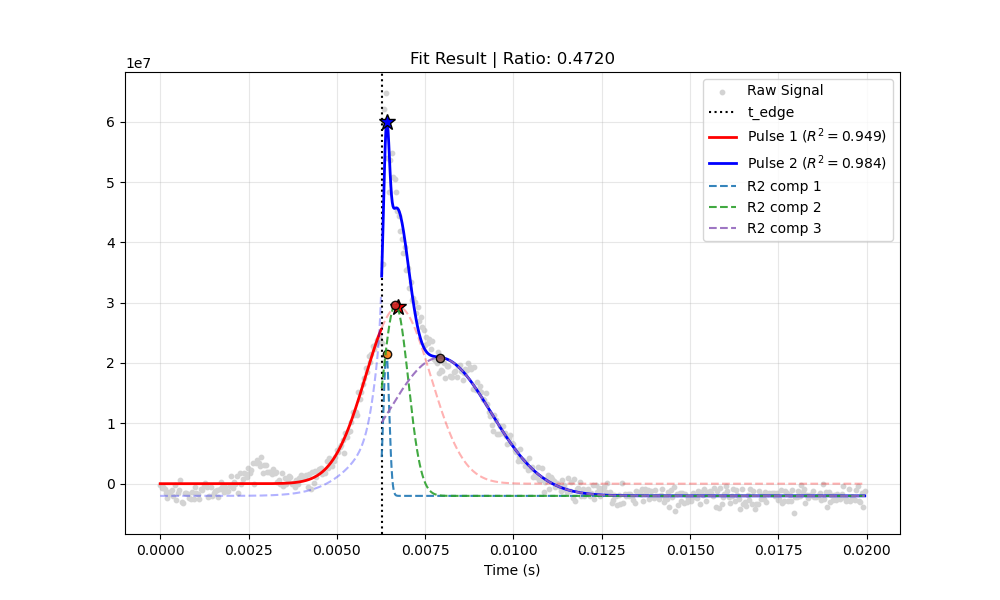

In [230]:
# --- SETTINGS ---
FILE_INDEX = 29    # e.g., scan_000.npz
TRACE_INDEX = 1   # 0 to 49
DATA_DIR = 'data' # Ensure this matches your folder name
# --- LOAD DATA ---
filename = f"scan_{FILE_INDEX:03d}.npz"
filepath = os.path.join(DATA_DIR, filename)

data = np.load(filepath)
time = data['time']

# Let's test on Condition A (you can swap to B easily)
signal = data['signals_a'][TRACE_INDEX]
t_edge = float(data['t_edge_a'])

# --- SPLIT REGIONS ---
split_idx = np.searchsorted(time, t_edge)

t1, s1 = time[:split_idx], signal[:split_idx]
t2, s2 = time[split_idx:], signal[split_idx:]

# Initialize: Choose 'sum' to get the peak of the combined pulses
processor = SignalProcessor(multi_pulse_return_mode='sum', fit_window = None)

# Run everything in one line
results = processor.run(time, signal, t_edge, region2_model='triple')

# Access data easily
print(f"Ratio: {results['ratio']:.4f}")
print(f"Region 2 Amp (Sum Peak): {results['region2']['amplitude']:.4f}")
print(f"Region 1 Amp: {results['region1']['amplitude']:.4f}")

processor.plot_result(results)

In [217]:
(0.00868 - 0.006267) / (d_t)

59.030679767395235

In [216]:
result

{'ratio': 0.4525151364611551,
 'ratio_uncertainty': np.float64(0.1463805616940017),
 't_edge': 0.006267,
 'fit_window': None,
 'region1': {'amplitude': 30191710.758531988,
  'uncertainty': 2391640.743391269,
  'params': array([ 3.01917108e+07,  6.28044653e-03,  5.05455528e-04, -2.30549437e+05]),
  'pcov': array([[ 5.71994545e+12,  2.34005819e+02,  1.16082443e+02,
          -1.23021749e+11],
         [ 2.34005819e+02,  1.23103261e-08,  6.77948586e-09,
          -4.13244860e+00],
         [ 1.16082443e+02,  6.77948586e-09,  4.20115309e-09,
          -3.87535575e+00],
         [-1.23021749e+11, -4.13244860e+00, -3.87535575e+00,
           6.77790423e+10]]),
  'cov': array([[ 5.71994545e+12,  2.34005819e+02,  1.16082443e+02,
          -1.23021749e+11],
         [ 2.34005819e+02,  1.23103261e-08,  6.77948586e-09,
          -4.13244860e+00],
         [ 1.16082443e+02,  6.77948586e-09,  4.20115309e-09,
          -3.87535575e+00],
         [-1.23021749e+11, -4.13244860e+00, -3.87535575e+00,
  

## Sin wave Extraction

<>:131: SyntaxWarning: invalid escape sequence '\p'
<>:131: SyntaxWarning: invalid escape sequence '\p'
/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/2694045040.py:131: SyntaxWarning: invalid escape sequence '\p'
  f"Phase Shift: {phase_mrad:.2f} $\pm$ {phase_err_mrad:.2f} mrad")


Loading data/scan_011.npz...
Processing 50 traces for Condition a...


Analyzing a:   0%|          | 0/50 [00:00<?, ?trace/s]/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/963499638.py:247: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)
/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/963499638.py:271: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)
Analyzing a: 100%|██████████| 50/50 [01:49<00:00,  2.20s/trace]


>>> RESULT: Scan 11 (a) | Phase Shift: -537.20 $\pm$ 152.21 mrad


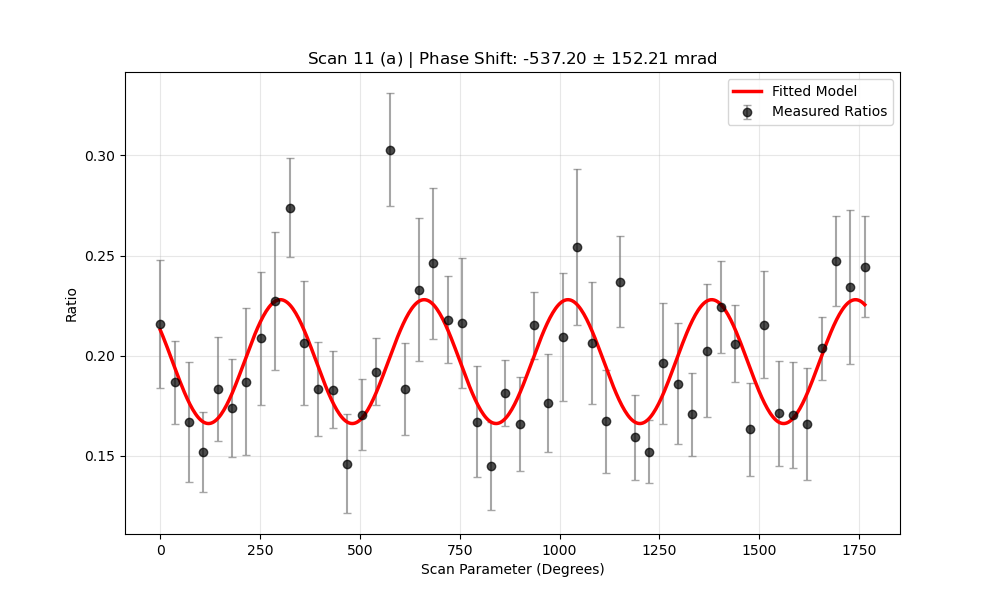

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm  # <--- NEW IMPORT

# Import your saved class
# If you haven't saved the file yet, paste the SignalProcessor class definition here instead.
# ==========================================
# 2. PHYSICS ENGINE (Sine Wave Fitter)
# ==========================================
class FringeAnalyzer:
    def __init__(self):
        pass
        
    def _sine_model(self, x_deg, A, phi, C):
        """
        Model: y = C + A * sin(x_deg * pi/180 + phi)
        """
        x_rad = np.deg2rad(x_deg)
        return C + A * np.sin(x_rad + phi)

    def fit(self, scan_params, ratios, ratio_errs):
        # Filter out NaNs (failed fits)
        valid_mask = ~np.isnan(ratios) & ~np.isnan(ratio_errs)
        x = scan_params[valid_mask]
        y = ratios[valid_mask]
        sigma = ratio_errs[valid_mask]
        
        if len(x) < 4: 
            return None
        
        try:
            guess_A = (np.max(y) - np.min(y)) / 2
            guess_C = np.mean(y)
            guess_phi = 0
            p0 = [guess_A, guess_phi, guess_C]
            
            popt, pcov = curve_fit(
                self._sine_model, x, y, p0=p0, sigma=sigma, absolute_sigma=True, maxfev=5000
            )
            
            return {
                'phase_rad': popt[1],
                'phase_err': np.sqrt(np.diag(pcov))[1],
                'amplitude': popt[0],
                'offset': popt[2],
                'params': popt
            }
        except Exception as e:
            print(f"Fringe fit failed: {e}")
            return None

# ==========================================
# 3. MAIN EXECUTION FUNCTION
# ==========================================
def run_full_analysis(file_index, condition='A'):
    # --- CONFIGURATION ---
    processor_settings = {
        'fit_window': None,        
        'region2_model': 'triple', 
        'multi_pulse_return_mode': 'sum' 
    }
    
    # --- LOAD DATA ---
    filename = f"data/scan_{file_index:03d}.npz"
    if not os.path.exists(filename):
        # Mocking data generation for demonstration if file doesn't exist
        print(f"File {filename} not found. Generating dummy data for test...")
        signals = [np.random.normal(0, 0.1, 1000) for _ in range(50)]
        scan_params = np.linspace(0, 360, 50)
        time = np.linspace(0, 0.01, 1000)
        t_edge = 0.002
    else:
        print(f"Loading {filename}...")
        data = np.load(filename)
        time = data['time']
        if condition == 'A':
            signals = data['signals_a']
            scan_params = data['scan_param_a']
            t_edge = float(data['t_edge_a'])
        else:
            signals = data['signals_b']
            scan_params = data['scan_param_b']
            t_edge = float(data['t_edge_b'])

    # --- PROCESS TRACES ---
    processor = SignalProcessor(**processor_settings)
    fitter = FringeAnalyzer()
    
    results_ratios = []
    results_uncertainties = []
    
    print(f"Processing {len(signals)} traces for Condition {condition}...")
    
    # <--- TQDM ADDED HERE
    # We wrap the range/iterator with tqdm()
    # 'desc' adds a label to the progress bar
    # 'unit' defines the unit of work (traces)
    for i in tqdm(range(len(signals)), desc=f"Analyzing {condition}", unit="trace"):
        
        # Run the processor on each trace
        res = processor.run(time, signals[i], t_edge)
        
        # Store results
        results_ratios.append(res['ratio'])
        results_uncertainties.append(res['ratio_uncertainty'])

    # Convert to numpy arrays
    y_data = np.array(results_ratios)
    y_err = np.array(results_uncertainties)
    x_data = np.array(scan_params)

    # --- FIT SINE WAVE ---
    fringe_res = fitter.fit(x_data, y_data, y_err)

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    
    plt.errorbar(x_data, y_data, yerr=y_err, fmt='o', color='black', 
                 ecolor='grey', elinewidth=1.5, capsize=3, alpha=0.7, label='Measured Ratios')
    
    if fringe_res:
        x_smooth = np.linspace(x_data.min(), x_data.max(), 500)
        y_smooth = fitter._sine_model(x_smooth, *fringe_res['params'])
        plt.plot(x_smooth, y_smooth, 'r-', linewidth=2.5, label='Fitted Model')
        
        phase_mrad = fringe_res['phase_rad'] * 1000
        phase_err_mrad = fringe_res['phase_err'] * 1000
        title = (f"Scan {file_index} ({condition}) | "
                 f"Phase Shift: {phase_mrad:.2f} $\pm$ {phase_err_mrad:.2f} mrad")
        print(f"\n>>> RESULT: {title}")
    else:
        title = f"Scan {file_index} ({condition}) | Fit Failed"
        print("\n>>> RESULT: Fit Failed")

    plt.title(title)
    plt.xlabel("Scan Parameter (Degrees)")
    plt.ylabel("Ratio")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 4. RUN IT
# ==========================================
if __name__ == "__main__":
    # If you don't have local data, this will run on dummy data
    run_full_analysis(file_index=11, condition='a')

## Batch Run

In [104]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

# from your_module import SignalProcessor  # <-- uncomment if you saved it as a module


# ==========================
# Fringe Analyzer (your code)
# ==========================
class FringeAnalyzer:
    def __init__(self):
        pass

    def _sine_model(self, x_deg, A, phi, C):
        x_rad = np.deg2rad(x_deg)
        return C + A * np.sin(x_rad + phi)

    def fit(self, scan_params, ratios, ratio_errs):
        valid_mask = np.isfinite(ratios) & np.isfinite(ratio_errs) & (ratio_errs > 0)
        x = np.asarray(scan_params)[valid_mask]
        y = np.asarray(ratios)[valid_mask]
        sigma = np.asarray(ratio_errs)[valid_mask]

        if len(x) < 4:
            return None

        try:
            guess_A = (np.max(y) - np.min(y)) / 2
            guess_C = np.mean(y)
            guess_phi = 0.0
            p0 = [guess_A, guess_phi, guess_C]

            popt, pcov = curve_fit(
                self._sine_model, x, y, p0=p0, sigma=sigma, absolute_sigma=True, maxfev=5000
            )

            perr = np.sqrt(np.diag(pcov))
            return {
                "phase_rad": float(popt[1]),
                "phase_err": float(perr[1]),
                "amplitude": float(popt[0]),
                "offset": float(popt[2]),
                "params": popt,
                "pcov": pcov,
                "n_used": int(len(x)),
                "valid_mask": valid_mask,
            }
        except Exception as e:
            print(f"Fringe fit failed: {e}")
            return None


# ==========================
# Single file-condition runner
# ==========================
def run_file_condition(
    filename: str,
    condition: str,
    processor,
    fit_window: float,
    make_plot: bool = False,
    out_plot_path: str | None = None,
):
    data = np.load(filename)

    time = data["time"]
    if condition.upper() == "A":
        signals = data["signals_a"]
        scan_params = data["scan_param_a"]
        t_edge = float(data["t_edge_a"])
    else:
        signals = data["signals_b"]
        scan_params = data["scan_param_b"]
        t_edge = float(data["t_edge_b"])

    fitter = FringeAnalyzer()

    n_traces = len(signals)
    ratios = np.full(n_traces, np.nan, dtype=float)
    ratio_unc = np.full(n_traces, np.nan, dtype=float)

    # Collect some per-trace diagnostics for debugging
    r1_A = np.full(n_traces, np.nan)
    r2_A = np.full(n_traces, np.nan)
    r1_r2 = np.full(n_traces, np.nan)
    r2_r2 = np.full(n_traces, np.nan)
    r1_rmse = np.full(n_traces, np.nan)
    r2_rmse = np.full(n_traces, np.nan)
    r2_sum_amp = np.full(n_traces, np.nan)

    for i in range(n_traces):
        res = processor.run(time, signals[i], t_edge, fit_window=fit_window)

        ratios[i] = res["ratio"]
        ratio_unc[i] = res["ratio_uncertainty"]

        # Diagnostics
        r1 = res["region1"]
        r2 = res["region2"]
        if r1.get("success", False):
            r1_A[i] = r1.get("amplitude", np.nan)
            r1_r2[i] = r1.get("r_squared", np.nan)
            r1_rmse[i] = r1.get("rmse", np.nan)
        if r2.get("success", False):
            r2_A[i] = r2.get("amplitude", np.nan)
            r2_r2[i] = r2.get("r_squared", np.nan)
            r2_rmse[i] = r2.get("rmse", np.nan)
            r2_sum_amp[i] = r2.get("amplitude", np.nan)

    fringe = fitter.fit(scan_params, ratios, ratio_unc)

    # Optional plot
    if make_plot:
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            scan_params, ratios, yerr=ratio_unc, fmt="o",
            color="black", ecolor="grey", elinewidth=1.2, capsize=2,
            alpha=0.75, label="Ratios"
        )

        title = f"{os.path.basename(filename)} ({condition}) | Fit Failed"
        if fringe is not None:
            x_smooth = np.linspace(np.min(scan_params), np.max(scan_params), 600)
            y_smooth = fitter._sine_model(x_smooth, *fringe["params"])
            plt.plot(x_smooth, y_smooth, linewidth=2.0, label="Sine fit")

            phase_mrad = fringe["phase_rad"] * 1000.0
            phase_err_mrad = fringe["phase_err"] * 1000.0
            title = (
                f"{os.path.basename(filename)} ({condition}) | "
                f"Phase: {phase_mrad:.2f} ± {phase_err_mrad:.2f} mrad"
            )

        plt.title(title)
        plt.xlabel("Scan Parameter (deg)")
        plt.ylabel("Ratio")
        plt.grid(True, alpha=0.3)
        plt.legend()
        if out_plot_path:
            plt.tight_layout()
            plt.savefig(out_plot_path, dpi=150)
        plt.close()

    # Package outputs
    out = {
        "time": time,
        "scan_params": scan_params,
        "t_edge": t_edge,
        "ratios": ratios,
        "ratio_unc": ratio_unc,
        "diag": {
            "r1_A": r1_A,
            "r2_A": r2_A,
            "r1_r2": r1_r2,
            "r2_r2": r2_r2,
            "r1_rmse": r1_rmse,
            "r2_rmse": r2_rmse,
            "r2_sum_amp": r2_sum_amp,
        },
        "fringe": fringe,
    }
    return out


# ==========================
# Batch runner
# ==========================
def batch_run(
    data_dir="data",
    out_dir="batch_results",
    n_files=30,
    fit_window=0.006,
    region2_model="triple",
    multi_pulse_return_mode="sum",
    make_plots=True,
):
    os.makedirs(out_dir, exist_ok=True)
    npz_dir = os.path.join(out_dir, "npz")
    plot_dir = os.path.join(out_dir, "plots")
    os.makedirs(npz_dir, exist_ok=True)
    if make_plots:
        os.makedirs(plot_dir, exist_ok=True)

    # Create processor once (reused)
    processor = SignalProcessor(
        region2_model=region2_model,
        multi_pulse_return_mode=multi_pulse_return_mode,
        fit_window=fit_window,
    )

    summary_rows = []

    for file_idx in tqdm(range(n_files), desc="Files", unit="file"):
        filename = os.path.join(data_dir, f"scan_{file_idx:03d}.npz")
        if not os.path.exists(filename):
            print(f"Missing: {filename} (skipping)")
            continue

        for cond in ["A", "B"]:
            plot_path = None
            if make_plots:
                plot_path = os.path.join(plot_dir, f"scan_{file_idx:03d}_{cond}.png")

            out = run_file_condition(
                filename=filename,
                condition=cond,
                processor=processor,
                fit_window=fit_window,
                make_plot=make_plots,
                out_plot_path=plot_path,
            )

            # Save detailed arrays to NPZ
            out_npz = os.path.join(npz_dir, f"scan_{file_idx:03d}_{cond}.npz")
            fringe = out["fringe"]
            # Save fringe params safely
            fringe_dict = {} if fringe is None else {
                "phase_rad": fringe["phase_rad"],
                "phase_err": fringe["phase_err"],
                "amplitude": fringe["amplitude"],
                "offset": fringe["offset"],
                "n_used": fringe["n_used"],
            }

            np.savez_compressed(
                out_npz,
                time=out["time"],
                scan_params=out["scan_params"],
                t_edge=out["t_edge"],
                ratios=out["ratios"],
                ratio_unc=out["ratio_unc"],
                r1_A=out["diag"]["r1_A"],
                r2_A=out["diag"]["r2_A"],
                r1_r2=out["diag"]["r1_r2"],
                r2_r2=out["diag"]["r2_r2"],
                r1_rmse=out["diag"]["r1_rmse"],
                r2_rmse=out["diag"]["r2_rmse"],
                r2_sum_amp=out["diag"]["r2_sum_amp"],
                fringe_json=json.dumps(fringe_dict),
            )

            # Summary row (one per file-condition)
            ratios = out["ratios"]
            unc = out["ratio_unc"]
            valid = np.isfinite(ratios) & np.isfinite(unc) & (unc > 0)

            row = {
                "file_idx": file_idx,
                "condition": cond,
                "filename": os.path.basename(filename),
                "n_traces": len(ratios),
                "n_valid": int(np.sum(valid)),
                "ratio_mean": float(np.nanmean(ratios)),
                "ratio_std": float(np.nanstd(ratios)),
                "median_r2_region2": float(np.nanmedian(out["diag"]["r2_r2"])),
                "median_rmse_region2": float(np.nanmedian(out["diag"]["r2_rmse"])),
                "fit_window": fit_window,
                "region2_model": region2_model,
                "return_mode": multi_pulse_return_mode,
            }

            if fringe is not None:
                row.update({
                    "phase_rad": fringe["phase_rad"],
                    "phase_err": fringe["phase_err"],
                    "phase_mrad": fringe["phase_rad"] * 1000.0,
                    "phase_err_mrad": fringe["phase_err"] * 1000.0,
                    "fringe_amp": fringe["amplitude"],
                    "fringe_offset": fringe["offset"],
                    "fringe_n_used": fringe["n_used"],
                })
            else:
                row.update({
                    "phase_rad": np.nan,
                    "phase_err": np.nan,
                    "phase_mrad": np.nan,
                    "phase_err_mrad": np.nan,
                    "fringe_amp": np.nan,
                    "fringe_offset": np.nan,
                    "fringe_n_used": 0,
                })

            summary_rows.append(row)

    # Save summary CSV
    df = pd.DataFrame(summary_rows)
    csv_path = os.path.join(out_dir, "summary.csv")
    df.to_csv(csv_path, index=False)

    print(f"\nSaved summary: {csv_path}")
    print(f"Saved per-scan NPZ files: {npz_dir}")
    if make_plots:
        print(f"Saved plots: {plot_dir}")


if __name__ == "__main__":
    # Adjust paths to match your setup
    batch_run(
        data_dir="data",
        out_dir="batch_results",
        n_files=30,
        fit_window=0.006,
        region2_model="triple",
        multi_pulse_return_mode="sum",
        make_plots=True,
    )


Files:   0%|          | 0/30 [00:00<?, ?file/s]/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/119945204.py:231: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)
/var/folders/g5/qd11www11315tzhgnsv03svr0000gn/T/ipykernel_18607/119945204.py:257: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  sample_params = rng.multivariate_normal(popt, pcov_psd)
Files: 100%|██████████| 30/30 [2:24:23<00:00, 288.79s/file]  


Saved summary: batch_results/summary.csv
Saved per-scan NPZ files: batch_results/npz
Saved plots: batch_results/plots
